# Comparing Traditional Time-Series Forecasting Methods with Time-Series Transformers

## Introduction
In the recent year, there has been a significant shift in the field of time-series forecasting. some may said the ImageNet moment for time-sereis. Major tech companies such as Amazon, Google, and Salesforce, among others, have introduced open-source transformers specifically designed for time-series forecasting. These models claim to outperform traditional forecasting methods in accuracy and efficiency. In this notebook, we will explore and compare traditional time-series forecasting methods like ARIMA, Exponential Smoothing, and Prophet with these new time-series transformers, specifically Chronos and Moirai-MoE, to predict the actual price of energy.

## Dataset

The dataset used in this study comprises weather and energy data from Spain, collected between 2014 and 2019. It includes various features such as temperature, wind speed, energy generation, and consumption. Our target variable is the actual price of energy, which we aim to forecast using different methodologies.

### Exploratory Data Analysis (EDA)

During the EDA phase, we will conduct data preprocessing and feature extraction specifically tailored for time-series data. This involves handling missing values, identifying and addressing non-stationary series, and extracting key features such as seasonal patterns, trends, and autocorrelation (ACF). These steps are crucial for understanding the underlying structure of the data and preparing it for more effective modeling.


We will apply each forecasting method to the dataset and evaluate their performance using metrics such as RMSE and MAPE.

## Traditional Methods
1. **ARIMA (AutoRegressive Integrated Moving Average)**
2. **Exponential Smoothing**

These methods will be applied to the dataset to establish a baseline performance for forecasting.

## Time-Series Transformers

1. **Chronos**
2. **Moirai-MoE**

The transformers used in this comparison are pre-trained on other datasets and fine-tuned for our specific task. These models will be evaluated in a zero-shot setting, where they are directly applied to our dataset without additional training.

## Results and Comparison

- **Performance Metrics**: We will calculate RMSE, MAPE, and other relevant metrics to quantify the accuracy of each method.
- **Visual Comparisons**: Plots will be generated to visually compare the forecasts from traditional methods and transformers.

## Conclusion

The final section will discuss the strengths and weaknesses of each approach, highlighting the conditions under which each method performs best.


In [415]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import math
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima import preprocessing as ppc
from pmdarima import pipeline
from pmdarima import model_selection
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder


## Dataset Overview

The dataset used in this study spans four years, from 2014 to 2019, and includes various aspects of electrical consumption, generation, pricing, and weather data for Spain. This comprehensive dataset was compiled from several sources to provide a detailed view of the energy market and its influencing factors during this period.

### Data Sources
- **Electrical Consumption and Generation**: The data was sourced from ENTSOE, a public portal that provides data from Transmission Service Operators (TSOs). This includes detailed records of energy consumption and various methods of energy generation across Spain.
- **Settlement Prices**: Pricing data was retrieved from the Spanish TSO, Red Eléctrica de España. This provides the actual settlement prices for energy, which is crucial for understanding the market dynamics.
- **Weather Data**: Weather information was obtained from the Open Weather API and covers the five largest cities in Spain. This data includes various meteorological parameters, which are essential 


In [416]:
# read weather datasets, turn the dt_iso column into a datetime object
df_weather = pd.read_csv(
    'datasets/weather_features.csv'
)
# read energy dataset, turn the time column into a datetime object
df_energy = pd.read_csv(
    'datasets/energy_dataset.csv'
)
df_energy['time'] = pd.to_datetime(df_energy['time'],utc=True)
# Set the 'time' column as the index
df_energy.set_index('time', inplace=True)

df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'],utc=True)
df_weather['time'] = df_weather['dt_iso']
df_weather['time'] = pd.to_datetime(df_weather['time'],utc=True)
df_weather.index = df_weather['time']
df_weather = df_weather.drop(['dt_iso'],axis=1)
# Filter out rows from 2014 for the energy dataset
df_energy = df_energy[df_energy.index.year > 2014]

# Filter out rows from 2014 for the weather dataset
df_weather = df_weather[df_weather.index.year > 2014]


### Exploratory Data Analysis (EDA)

In this section, we will begin by cleaning and preprocessing the energy dataset. First, we will examine the dataset using the `describe()` method to obtain an overview of the statistical properties of each column. Here are some of the columns we will inspect:

- **Generation Data**: This includes various energy generation methods such as biomass, fossil fuels (coal, gas, oil), hydro (pumped storage, run-of-river, and water reservoir), nuclear, wind, solar, and waste. These columns reflect the energy generation by different sources across Spain.
- **Forecast Data**: This includes the forecast values for solar, wind, and total load on a day-ahead basis.
- **Actual Energy Load and Prices**: These include the total load , as well as the day-ahead energy prices, which provide insights into the real-time energy market dynamics that we will want to predict.


In [417]:

# we will start analyzing the energy dataset
df_energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35044.000000,35045.000000,35045.0,35045.000000,35045.000000,35044.000000,35045.0,35045.0,35045.0,0.0,35044.000000,35044.000000,35045.000000,35044.0,35046.000000,35045.000000,35045.000000,35045.000000,35044.000000,35045.0,35045.000000,35063.000000,0.0,35063.000000,35063.000000,35027.000000,35063.000000,35063.000000
mean,383.511728,448.062605,0.0,5622.759709,4256.049622,298.323679,0.0,0.0,0.0,NaN,475.566288,972.113857,2605.134884,0.0,6263.883296,60.229077,85.640063,1432.705407,269.454229,0.0,5464.453702,1439.107293,NaN,5471.189174,28712.203947,28697.034459,49.874335,57.883808
std,85.354487,354.573079,0.0,2201.857963,1961.626679,52.516373,0.0,0.0,0.0,NaN,792.415217,400.783033,1835.222053,0.0,839.668173,20.238460,14.077593,1680.127600,50.194718,0.0,3213.733734,1677.710090,NaN,3176.353970,4594.145478,4575.019032,14.619108,14.204229
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.000000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.500000,24807.500000,41.490000,49.345000
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6565.500000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5839.000000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.500000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


We can see a lot of things from the `describe()` function about the dataset. First, we can see that there are some columns with only NaN values in them. This suggests that these columns might not contain any useful information for our analysis. We will calculate the percentage of NaN values in these columns to identify those that have a significant proportion of missing data. This will help us determine if there are other columns with a considerable amount of NaN values that might need to be dropped or handled with imputation. The goal is to clean the dataset and retain only the most useful features for building our models.


In [418]:
# Calculate the number of missing values for each column
missing_counts = df_energy.isna().sum()

# Calculate the percentage of missing values for each column
missing_percentages = (df_energy.isna().mean() * 100).sort_values(ascending=False)

missing_percentages.head(5)


generation hydro pumped storage aggregated    100.000000
forecast wind offshore eday ahead             100.000000
total load actual                               0.102672
generation waste                                0.054188
generation marine                               0.054188
dtype: float64

As observed, there are two columns that contain only NaN values(generation hydro pumped storage aggregated,forecast wind offshore eday ahead)), while the remaining columns have a relatively low percentage of missing values. We will keep the relatively low percentage columns for now and drop the NaN columns.


In [419]:
df_energy = df_energy.drop(['forecast wind offshore eday ahead', 'generation hydro pumped storage aggregated'],axis=1)


Eariler we saw on the df_energy.describe() that there are some colums with only 0 values, so they dont give us any information. so we will drop them also.

In [420]:

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation marine','generation wind offshore','generation geothermal'],axis=1)

### Dropping Forecast Columns

In this step, we drop all columns related to forecast data. These columns contain predicted values that are not useful for our analysis, as our goal is to forecast the energy prices ourselves. Keeping them in the dataset could introduce unnecessary biases or inaccuracies. Therefore, we remove any columns whose names contain the word "forecast" to ensure we only work with the relevant data for our own forecasting task.


In [421]:
to_drop = [col for col in df_energy.columns if 'forecast' in col]
print(to_drop)
df_energy = df_energy.drop(to_drop, axis=1)

['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast']


In this step, we calculate the number of missing (NaN) values for each column in the dataset. We then plot a bar chart to visualize the count of missing values for columns that have missing data.

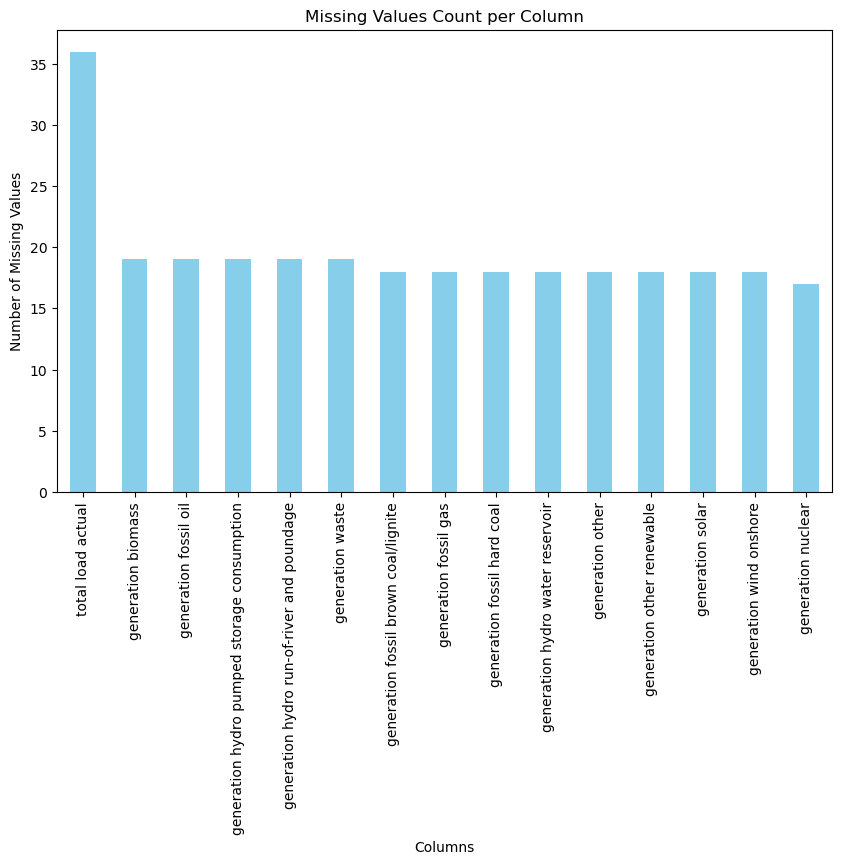

In [422]:
missing_count = df_energy.isna().sum()

# Plotting the missing values count
plt.figure(figsize=(10, 6))
missing_count[missing_count > 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Missing Values Count per Column")
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.show()


As we can see, comparing to a 35045 samples, the column with the most nan values have only 34 NaN, so it not a critical error.

In [423]:
# # Select numerical columns for plotting
# columns = df_energy.select_dtypes(include=['float64', 'int64']).columns

# # Calculate grid size (e.g., 2 columns per row)
# ncols = 4
# nrows = int(np.ceil(len(columns) / ncols))

# # Create subplots
# f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
# f.suptitle('Boxplots of Energy Features', weight='bold', fontsize=25)

# # Flatten axes array and iterate over columns
# axes = axes.flatten()
# for i, col in enumerate(columns):
#     sns.boxplot(data=df_energy, x=col, ax=axes[i], color='#cc444b', width=0.5)
#     axes[i].set_title(f"Boxplot of {col}", fontsize=12)
#     axes[i].set_xlabel('')  # Remove x-axis label for cleanliness

# # Remove unused subplots if columns are fewer than grid slots
# for j in range(i + 1, len(axes)):
#     f.delaxes(axes[j])

# # Adjust layout
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
# plt.show()

if we look closely, we are see some outliers, not alot of them though. we will fill them up with a 
FIGURE OUT



In this step, we create a plot of the 'Total Load Actual' against time to visualize the data over a specific time range. By zooming in on a particular period (from '2015-01-01' to '2015-02-02'), we can better observe the trends, patterns, and any potential gaps or anomalies in the data. This visualization will help us understand the behavior of the 'Total Load Actual' variable, which is crucial for deciding how to handle missing values and perform imputation. The goal is to examine the time-series data to inform our approach to filling any gaps, whether through interpolation or other methods.


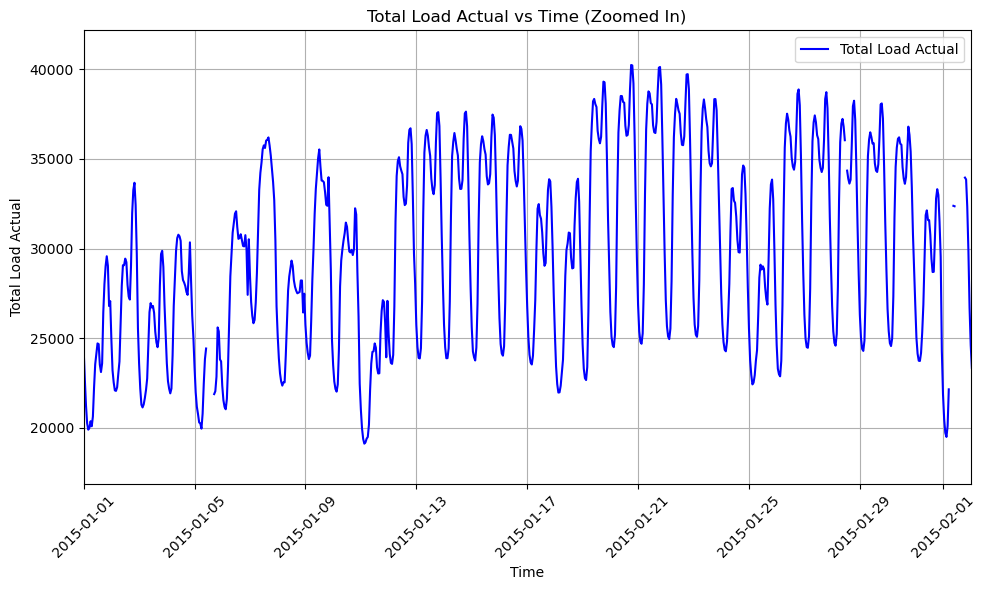

In [424]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_energy.index, df_energy['total load actual'], label='Total Load Actual', color='blue')

# Set x-axis limit to zoom into specific time range (e.g., from '2015-01-01' to '2015-02-02')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-02'))

plt.title('Total Load Actual vs Time (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


We can see that in the beginning of 2015-01-05 there is a missing value.
Time series data relies on the order and continuity of time-based observations. If you remove rows with missing data, you can break this continuity, leading to gaps in your time series, also , in more techinal approach, Many time series models (e.g., ARIMA, LSTM) require the data to be continuous and use previous observations to make predictions. Dropping rows can disturb this temporal relationship, leading to poor model performance.
so we will need to fill the missing values, as we can see in the plot we just plotted that the data of Load Actual is linear. so a good approach would be to use linear interplation in here.
2 more possible approachs that are common in time-series data is fill forward that will replaces NaN with the immediat next value, and backword fill thah replaces NaN with the immediate previous value.
The reason I am choosing linear interplation its becuase, as we can see there is a somekind of gap between night and day, which linear interploate will solve but the other methods can make a bigger gap and less smoother.

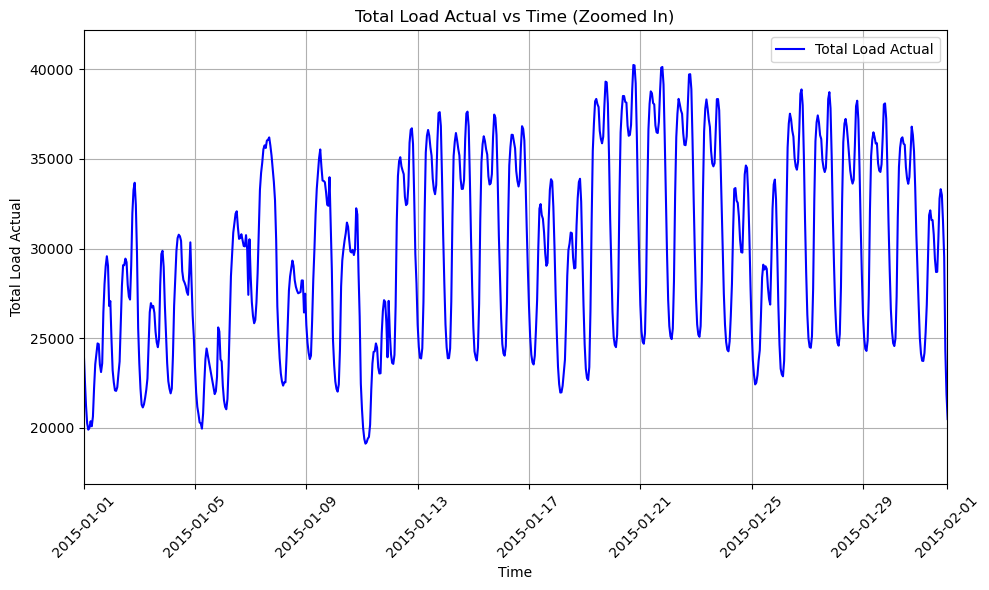

In [425]:

df_energy['total load actual'] = df_energy['total load actual'].interpolate(method='linear')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_energy.index, df_energy['total load actual'], label='Total Load Actual', color='blue')

# Set x-axis limit to zoom into specific time range (e.g., from '2015-01-01' to '2015-02-01')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))

plt.title('Total Load Actual vs Time (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

we can see that missing value is filled and the line looks "natural".

Now we will go all over our features and we would try to figure out how should we fill the missing values.

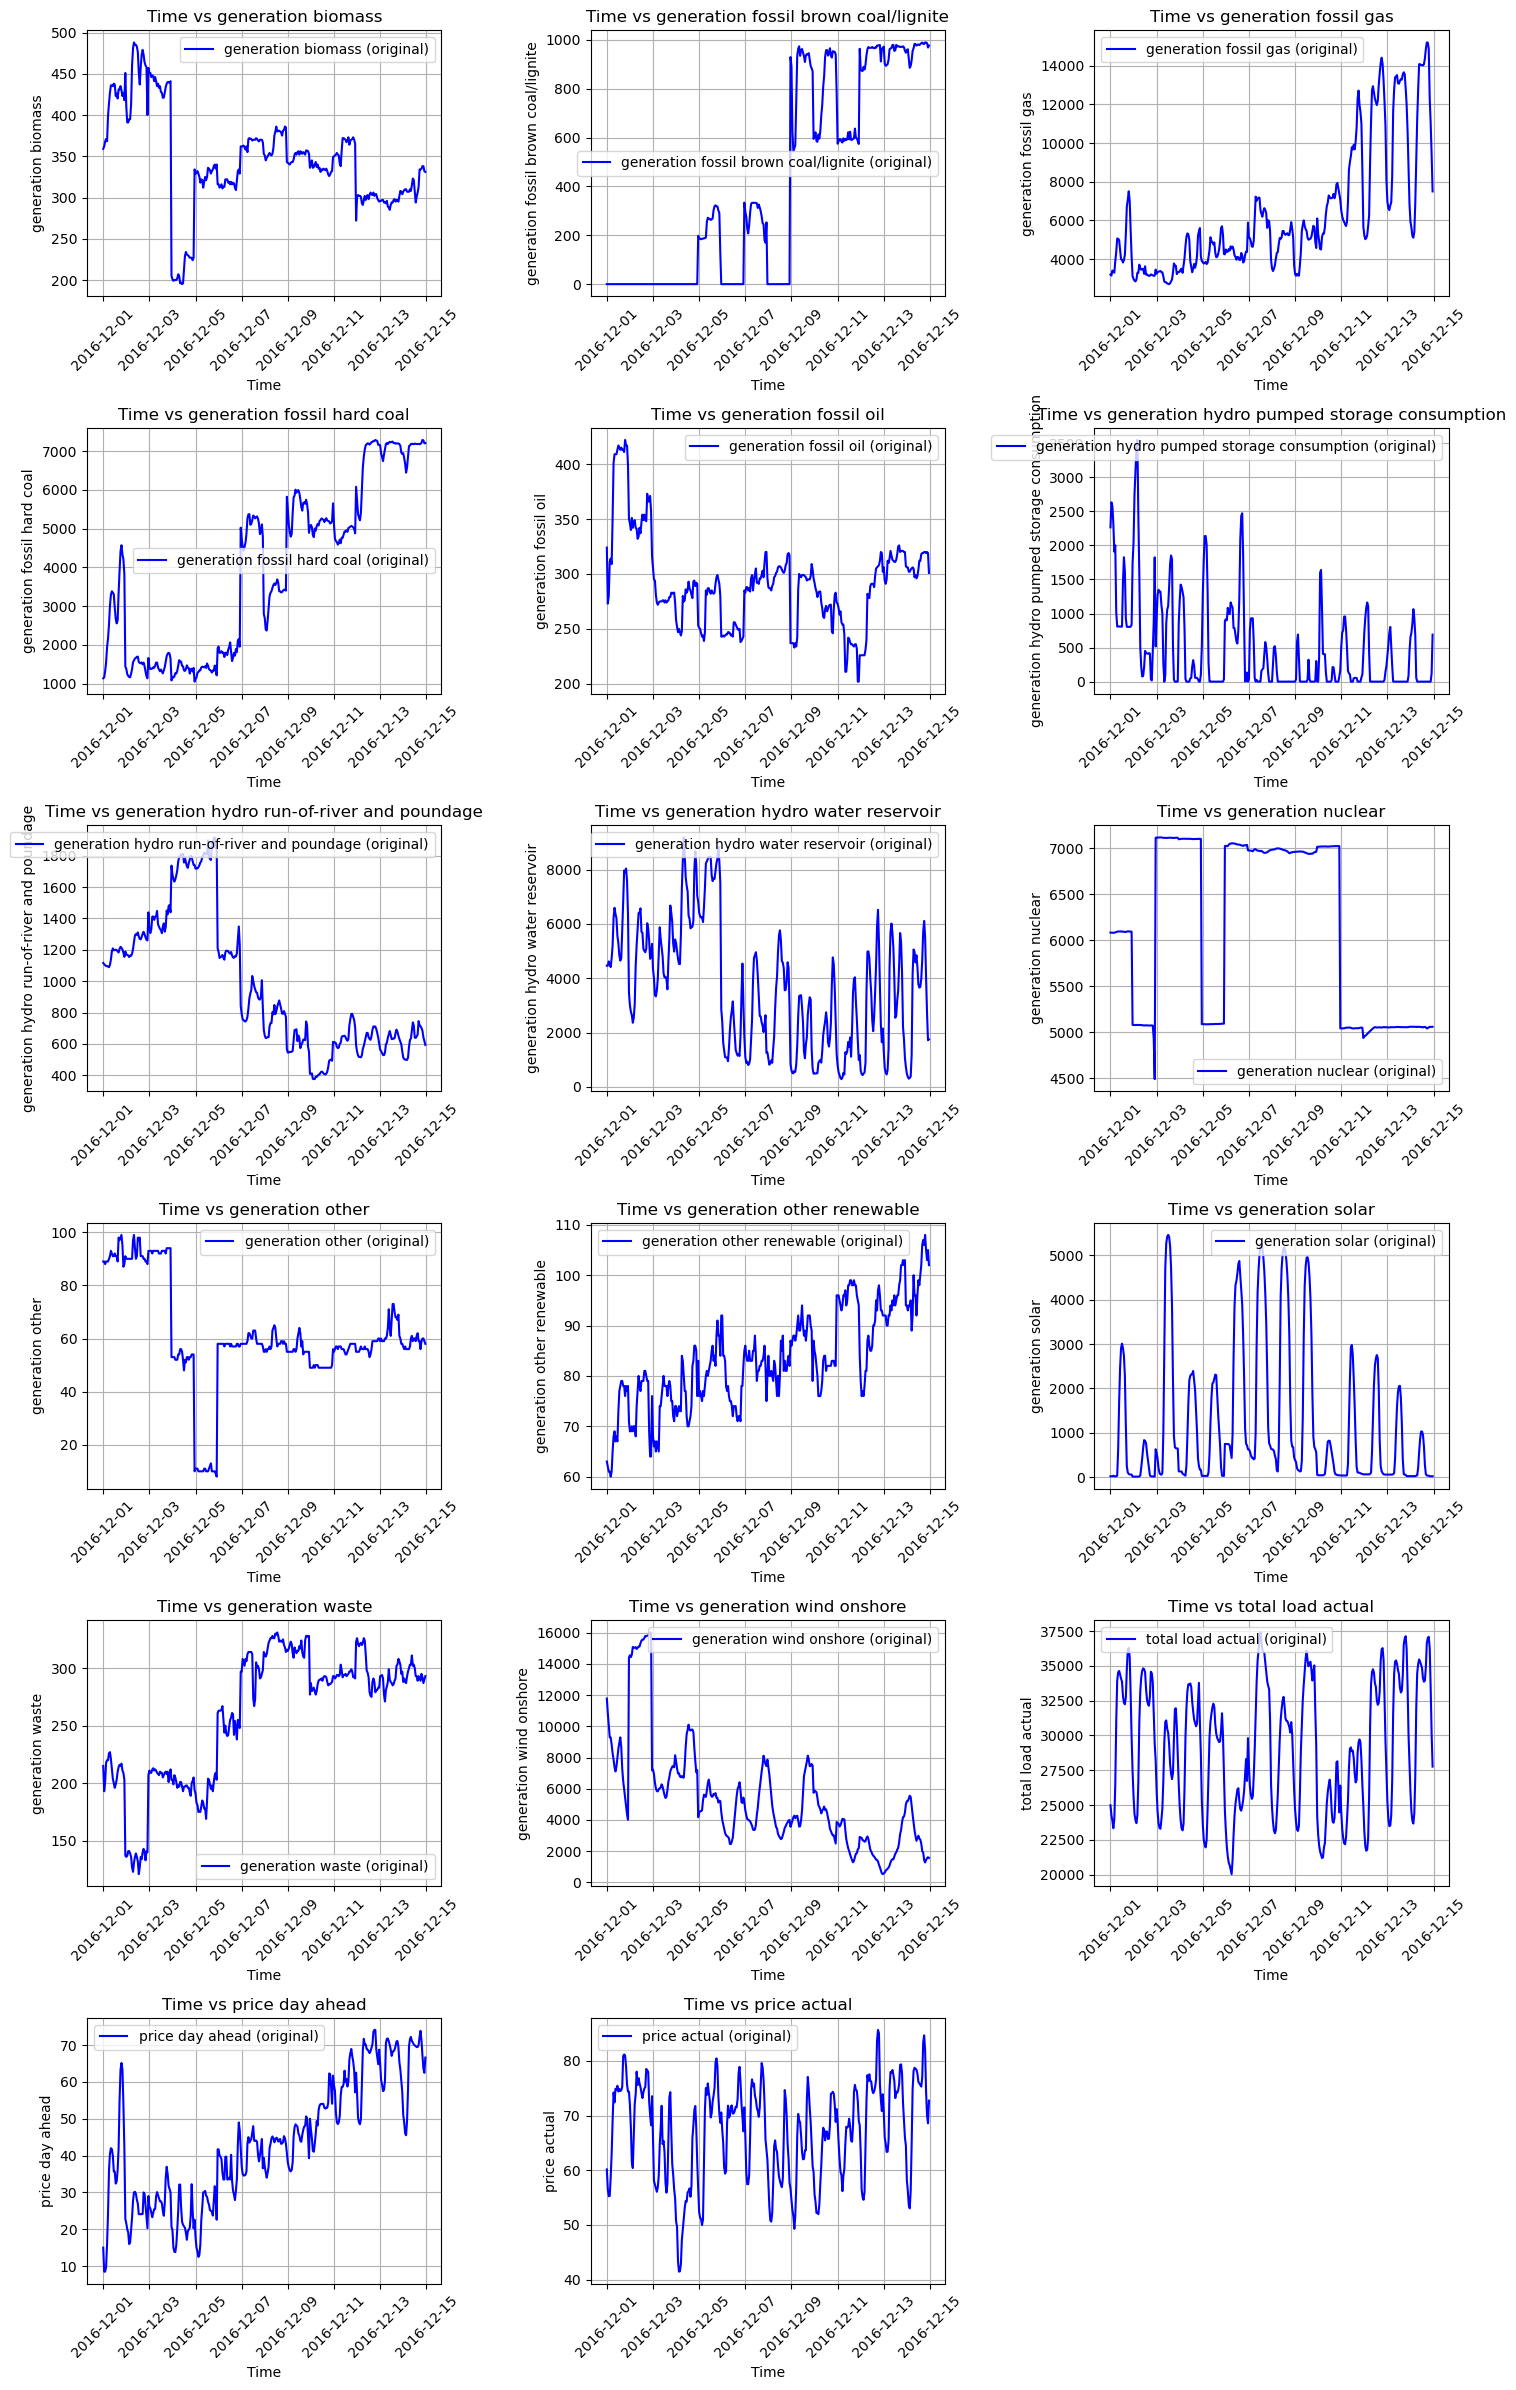

In [426]:
start_date = pd.Timestamp('2016-12-01 00:00:00', tz='UTC')
end_date = pd.Timestamp('2016-12-14 23:59:59', tz='UTC')

# Filter the DataFrame to include only the specific two-week period
df_two_weeks = df_energy.loc[start_date:end_date]
df_two_weeks.head()

# Get the number of columns to plot
columns = df_two_weeks.columns
n_columns = len(columns)

# Calculate the grid size
nrows = math.ceil(n_columns / 3)  # 3 columns per row
ncols = 3  # Fixed number of columns

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
axes = axes.flatten()  # Flatten to easily iterate over

for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(df_two_weeks.index, df_two_weeks[column], label=f"{column} (original)", color='blue')
    
    # Customize the plot
    ax.set_title(f"Time vs {column}")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{column}")
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

### Linear Interpolation for Missing Values

After plotting all the features and examining the time-series data, it appears that linear interpolation is the most suitable method to fill in the missing values. Linear interpolation works by estimating missing values based on the linear trend between available data points, making it a natural choice for time-series data where values are expected to change gradually over time.

By applying linear interpolation, we are ensuring that the filled values follow the same trend as the surrounding data points, rather than introducing artificial patterns or assumptions. This method is effective when the data does not exhibit sharp fluctuations or irregular patterns that would require more complex imputation methods, like polynomial or spline interpolation.

Thus, we use the `interpolate()` function with the `linear` method to fill the missing values and preserve the continuity of the time-series data.


In [427]:
df_energy = df_energy.interpolate(method='linear')

In [428]:
null_percentage = df_energy.isnull().sum()/len(df_energy) * 100   
print(null_percentage)
# we can see there is no more missing values in the dataset

generation biomass                             0.0
generation fossil brown coal/lignite           0.0
generation fossil gas                          0.0
generation fossil hard coal                    0.0
generation fossil oil                          0.0
generation hydro pumped storage consumption    0.0
generation hydro run-of-river and poundage     0.0
generation hydro water reservoir               0.0
generation nuclear                             0.0
generation other                               0.0
generation other renewable                     0.0
generation solar                               0.0
generation waste                               0.0
generation wind onshore                        0.0
total load actual                              0.0
price day ahead                                0.0
price actual                                   0.0
dtype: float64


In [429]:
zeros_percentage = (df_energy == 0).sum()/len(df_energy) * 100
print(zeros_percentage)

generation biomass                              0.011408
generation fossil brown coal/lignite           30.014545
generation fossil gas                           0.002852
generation fossil hard coal                     0.008556
generation fossil oil                           0.008556
generation hydro pumped storage consumption    35.975245
generation hydro run-of-river and poundage      0.008556
generation hydro water reservoir                0.008556
generation nuclear                              0.008556
generation other                                0.011408
generation other renewable                      0.008556
generation solar                                0.008556
generation waste                                0.008556
generation wind onshore                         0.008556
total load actual                               0.000000
price day ahead                                 0.000000
price actual                                    0.000000
dtype: float64



## Data Cleaning Summary: df_energy Dataset
Generation fossil brown coal/lignite: This column represents electricity production from lignite, a low-grade coal. While it is an affordable and locally abundant energy source, it is among the least environmentally friendly due to high carbon emissions and inefficiency. Spain's significant investments in renewable energy sources, such as wind, solar, and hydropower, have reduced reliance on lignite. As a result, its use is often limited to periods when renewable generation and other cleaner options cannot meet demand, explaining the presence of zeros in 30% of the data.

Hydro pumped storage consumption: This column shows 35% zeros, which is expected. Pumped storage is utilized only during energy surplus periods to store energy, remaining inactive when supply and demand are balanced or when conditions do not require its operation.

The percentage of zeros in these columns is reasonable and does not indicate any inaccuracies in the data.

With these steps, the df_energy dataset is sufficiently cleaned for further analysis. Future work may include additional feature engineering and processing as needed.

Now, let's proceed to clean the weather dataset.

In [430]:
df_weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178391.000000,178391.000000,178391.000000,1.783910e+05,178391.000000,178391.000000,178391.000000,178391.000000,178391.000000,178391.000000,178391.000000,178391.000000
mean,289.619085,288.330886,291.091788,1.069262e+03,68.423065,2.470573,166.592070,0.075494,0.000380,0.004763,25.073995,759.830776
std,8.025757,7.955117,8.611972,5.969716e+03,21.902944,2.095895,116.611933,0.398853,0.007289,0.222607,30.774274,108.734538
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.485000,284.650000,1.013000e+03,53.000000,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730750,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In the data set we have 5 major cities in Spain that been sampled through 2014-2018, as we can see they have been sampled hourly, the same as the df_energy dataset which is excellent for us.
The length of the dataframes is 178396 which is 35064(the lenght of the df_energy dataset) * 5.

as we can see here -


In [431]:
print(len(df_energy.index.unique()))
print(len(df_weather.index.unique()))

35063
35063


As we know, in time-series data, duplicates are not allowed. Additionally, when extracting each city as its own feature, duplicates can cause issues. 

In this case, we observe that the total number of unique rows is 35,064, but for each city, we have more than 35,064 rows. This indicates that duplicates exist, and we need to remove them in order to proceed correctly.


In [432]:
grouped = df_weather.groupby('city_name')
# Iterate over each group (city_name) and its corresponding DataFrame
def count_duplicate_times_by_city(grouped):
    for city, group in grouped:
    # Check for duplicates in the 'time' column
        duplicated_count = group['time'].duplicated().sum()
        print(f"City: {city}, Number of duplicated rows based on 'time': {duplicated_count}")
        print(f"Number of rows is {len(group)}")
        duplicated_rows = group[group['time'].duplicated(keep=False)]
count_duplicate_times_by_city(grouped)


City:  Barcelona, Number of duplicated rows based on 'time': 412
Number of rows is 35475
City: Bilbao, Number of duplicated rows based on 'time': 887
Number of rows is 35950
City: Madrid, Number of duplicated rows based on 'time': 1203
Number of rows is 36266
City: Seville, Number of duplicated rows based on 'time': 493
Number of rows is 35556
City: Valencia, Number of duplicated rows based on 'time': 81
Number of rows is 35144


In [433]:
# Group by 'time' and 'city_name' and filter for groups that have more than one row
duplicated_rows = df_weather[df_weather.duplicated(subset=['time', 'city_name'], keep=False)]

# Display the rows
print(duplicated_rows.head(10))


                          city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2015-01-06 03:00:00+00:00  Valencia  273.142   273.142   273.142       995   
2015-01-06 03:00:00+00:00  Valencia  273.142   273.142   273.142       995   
2015-06-15 19:00:00+00:00  Valencia  289.610   288.650   290.930      1018   
2015-06-15 19:00:00+00:00  Valencia  289.610   288.650   290.930      1018   
2015-06-15 20:00:00+00:00  Valencia  289.240   288.150   290.370      1018   
2015-06-15 20:00:00+00:00  Valencia  289.240   288.150   290.370      1018   
2015-07-18 17:00:00+00:00  Valencia  299.770   298.750   300.930      1013   
2015-07-18 17:00:00+00:00  Valencia  299.770   298.750   300.930      1013   
2015-07-31 21:00:00+00:00  Valencia  295.890   293.710   297.590      1009   
2015-07-31 21:00:00+00:00  Valencia  295.890   293.710   297.590      1009   

                           humidity  wind_speed  wind_deg  rain

As we can see, and after some manual(is it enough?) digging, The duplicated row mostly have the same values for the other columns.
so I will drop duplicates with keeping the first row(meaning that we will delete all the other rows that have the same 'time' and 'city_name')

In [434]:

df_weather = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='last')  # Keep the last occurrence


In [435]:
grouped = df_weather.groupby('city_name')
# Iterate over each group (city_name) and its corresponding DataFrame
def count_duplicate_times_by_city(grouped):
    for city, group in grouped:
    # Check for duplicates in the 'time' column
        duplicated_count = group['time'].duplicated().sum()
        print(f"City: {city}, Number of duplicated rows based on 'time': {duplicated_count}")
        print(f"Number of rows is {len(group)}")
        duplicated_rows = group[group['time'].duplicated(keep=False)]

count_duplicate_times_by_city(grouped)
    

City:  Barcelona, Number of duplicated rows based on 'time': 0
Number of rows is 35063
City: Bilbao, Number of duplicated rows based on 'time': 0
Number of rows is 35063
City: Madrid, Number of duplicated rows based on 'time': 0
Number of rows is 35063
City: Seville, Number of duplicated rows based on 'time': 0
Number of rows is 35063
City: Valencia, Number of duplicated rows based on 'time': 0
Number of rows is 35063


In [436]:
zeros_percentage = (df_weather == 0).sum()/len(df_weather) * 100
print(zeros_percentage)

city_name               0.000000
temp                    0.000000
temp_min                0.000000
temp_max                0.000000
pressure                0.001141
humidity                0.035935
wind_speed             10.335681
wind_deg               13.889285
rain_1h                90.079571
rain_3h                98.942475
snow_3h                99.847703
clouds_all             46.776374
weather_id              0.000000
weather_main            0.000000
weather_description     0.000000
weather_icon            0.000000
time                    0.000000
dtype: float64


as we can see, the rain_3h(3 hours of raining) is a data that already contanied in the rain_1h(1 hour of raining), so, to remove the redundancy we will remove it.
also, we will take a look at the other columns and figure out if there is some more cleaning we need to do.

In [437]:
df_weather = df_weather.drop(['rain_3h'],axis=1)
# df_weather.info()
# we see that there is some float64 and there is some int64, we will convert the int64 to float64
for col in df_weather.select_dtypes(include=['int64']).columns:
    df_weather[col] = df_weather[col].astype('float64')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175315 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   city_name            175315 non-null  object             
 1   temp                 175315 non-null  float64            
 2   temp_min             175315 non-null  float64            
 3   temp_max             175315 non-null  float64            
 4   pressure             175315 non-null  float64            
 5   humidity             175315 non-null  float64            
 6   wind_speed           175315 non-null  float64            
 7   wind_deg             175315 non-null  float64            
 8   rain_1h              175315 non-null  float64            
 9   snow_3h              175315 non-null  float64            
 10  clouds_all           175315 non-null  float64            
 11  weather_id         

All the columns but weather_id,weather_meain,weather dscription and weather_icon and very self-explanibale. 
so now we will try to understand what information each of these columns give us and we need them all.
if we look at the data bases in the kaggle there is a brief explantion for each column.
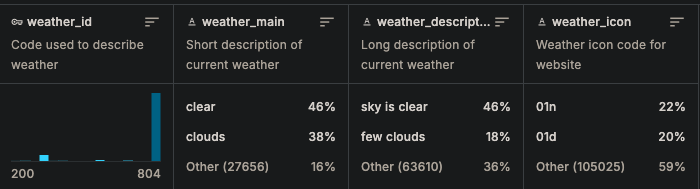



In this step, we encode the categorical features `weather_main` and `weather_description` in the `df_weather` DataFrame using `LabelEncoder`. This transformation converts the textual weather descriptions into numeric labels, making them suitable for correlation analysis and machine learning algorithms.

We print the unique encoded values for both `weather_main` and `weather_description` to understand the range of the encoded labels. Then, we calculate the correlation between `weather_main` and `weather_id` to check if these features convey similar information.

Since the correlation between `weather_main` and `weather_id` is very high, we decide to drop the `weather_id` column to avoid redundancy. Additionally, we drop the `weather_icon` column as it is not relevant for our analysis, and the `weather_description` column because its high specificity could lead to overfitting in our model.

This preprocessing step ensures that we retain only the most informative features while reducing potential noise and redundancy in our dataset.


In [438]:

le = LabelEncoder()
# Encode categorical features
df_weather['weather_main'] = le.fit_transform(df_weather['weather_main'])
df_weather['weather_description'] = le.fit_transform(df_weather['weather_description'])
print(df_weather['weather_main'].unique())
print(df_weather['weather_description'].unique())
# Print the correlation between `weather_main` and `weather_id`
print(f"Correlation between weather_main and weather_id: {df_weather['weather_main'].corr(df_weather['weather_id'])}")

# as we can see the correlation is very high, we will drop the weather_id column, also the weather_icon column(not relevant for us) and weathers_description(too much specific can give us overfitting)
df_weather = df_weather.drop(['weather_id', 'weather_icon', 'weather_description'], axis=1)


[ 0  1  7  6 11  2  4  8  5  9  3 10]
[33  3 30  0 21 13 20  7 19  8 31 42 39 40 41 25 38 12 10  4  1 35  6  5
 24 11 17 36 14 18 28  9 34 27 32 15 16 23 26 29 22  2 37]
Correlation between weather_main and weather_id: -0.8783430726614807



In this step, we prepare the dataset for correlation analysis by dropping non-numeric columns such as `city_name` and `time`, which are not relevant for correlation computation. We then calculate the correlation matrix for the remaining features in the `df_weather` DataFrame.

To visualize the correlations, we plot a heatmap using `seaborn`. The heatmap displays the correlation coefficients between different features, with values ranging from -1 to 1. A correlation close to 1 indicates a strong positive relationship, while a correlation close to -1 indicates a strong negative relationship. Values near 0 suggest no linear relationship.

The purpose of this correlation map is to identify features that are highly correlated with each other. When two features have a high correlation, one of them can often be dropped without losing much information. This step helps in reducing multicollinearity, simplifying the model, and improving its performance by retaining only the most informative features.


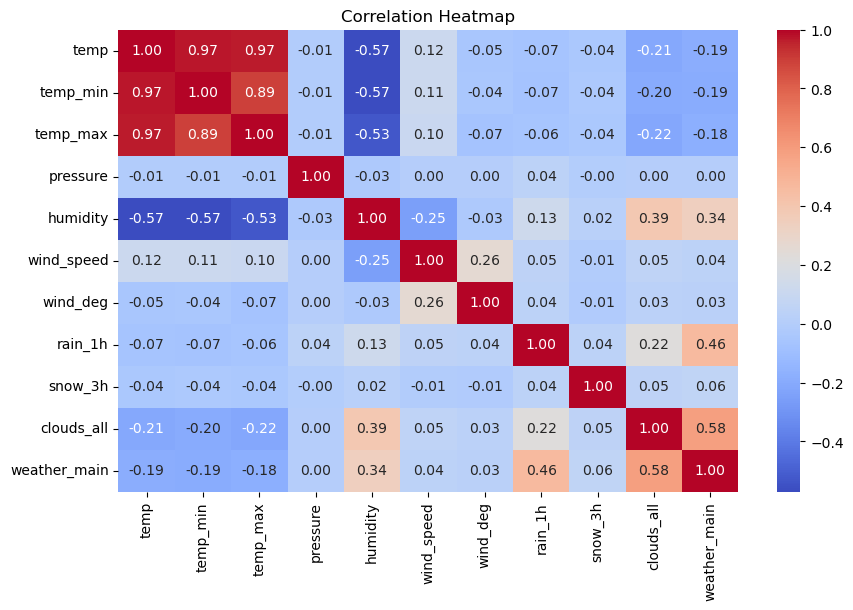

In [439]:
df_for_cor = df_weather.drop(['city_name','time'],axis=1)
corr = df_for_cor.corr()
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

we can see that temp min and temp max are very correlated and not adding any information(makes sense) so we will drop them.

In [440]:
df_weather.drop(['temp_min','temp_max'],axis=1,inplace=True)



In this step, we create boxplots for each numerical feature in the `df_weather` DataFrame. Boxplots are a useful visualization tool for identifying potential outliers within a dataset. They display the distribution of data points and highlight the median, quartiles, and any values that lie significantly outside the interquartile range (IQR).

We begin by selecting all numerical columns (`float64` and `int64` types) and determining the grid size for plotting, aiming for a clean layout with 4 columns per row. We then create subplots for each numerical feature, plotting individual boxplots with `seaborn`. The boxplots are colored consistently to maintain visual uniformity.

By visualizing all numerical features in this way, we can quickly identify which features contain outliers, allowing us to decide whether to address these outliers through methods such as data transformation, removal, or imputation.

This step is crucial for improving the robustness of our model by ensuring that extreme values do not skew the results or lead to inaccurate predictions.


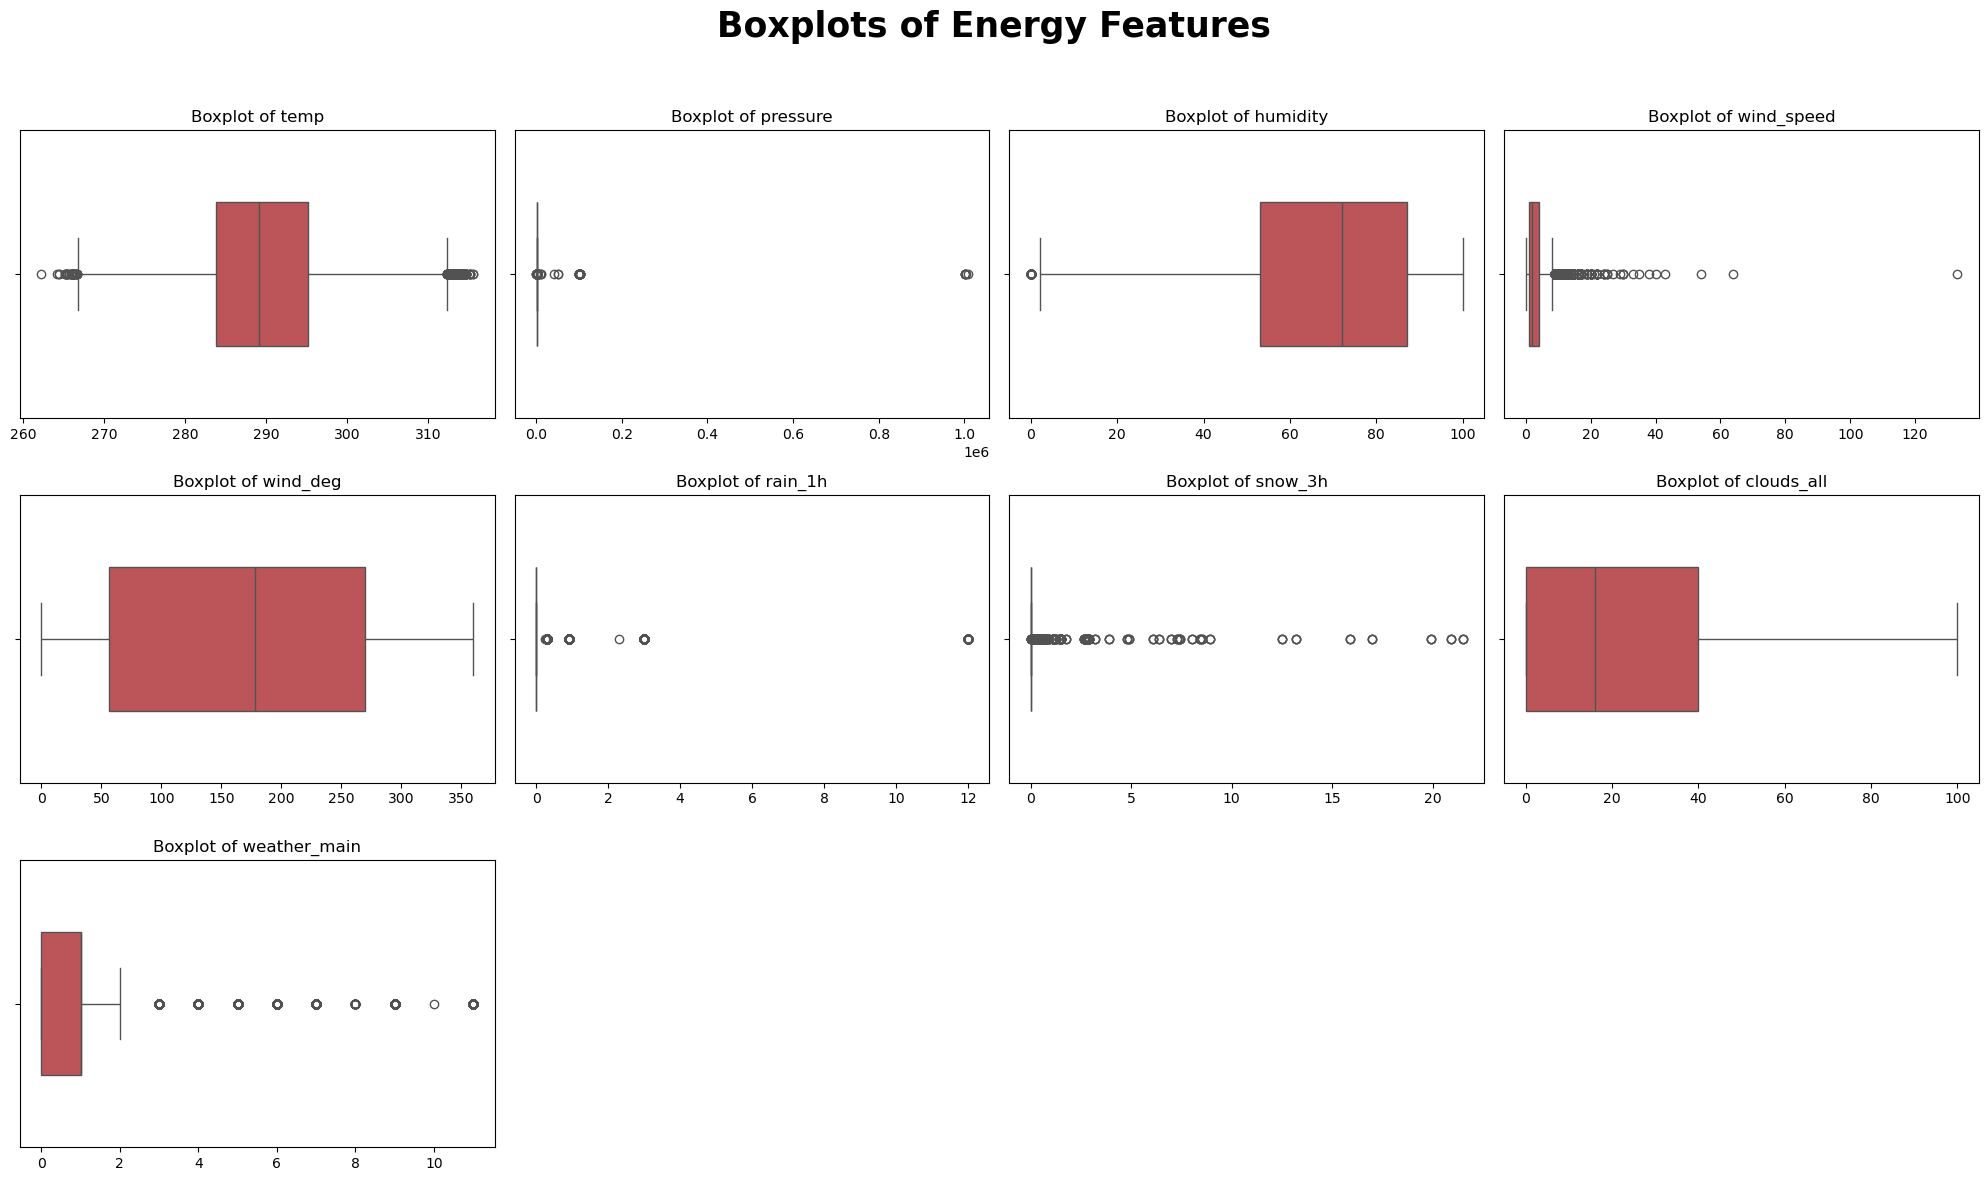

In [441]:
# Select numerical columns for plotting
columns = df_weather.select_dtypes(include=['float64', 'int64']).columns

# Calculate grid size (e.g., 2 columns per row)
ncols = 4
nrows = int(np.ceil(len(columns) / ncols))

# Create subplots
f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
f.suptitle('Boxplots of Energy Features', weight='bold', fontsize=25)

# Flatten axes array and iterate over columns
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.boxplot(data=df_weather, x=col, ax=axes[i], color='#cc444b', width=0.5)
    axes[i].set_title(f"Boxplot of {col}", fontsize=12)
    axes[i].set_xlabel('')  # Remove x-axis label for cleanliness

# Remove unused subplots if columns are fewer than grid slots
for j in range(i + 1, len(axes)):
    f.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

The noraml pressure level at sea level is about 1000 hPa, at the dead sea, where is the higgest pressure there is about 1100 hPa, so more then that its an outlier. and less then 700 hPa also outlier.
also, wind speed is in m/s, then to have 50 m/s is a high as 180 km/h wind, which is very very high. so, we will define wind more then 50 m/s is an outlier.
for presure we will use mean because pressure have a solid values who are not range so much.
for wind we will calculate the 95th percentile of wind speed and if its more then the 99 percentile we will replace the value to be the 95 percentile.

In [442]:
mean_pressure = df_weather['pressure'].mean()
df_weather.loc[df_weather['pressure'] > 1105, 'pressure'] = mean_pressure
df_weather.loc[df_weather['pressure'] < 700, 'pressure'] = mean_pressure
# Calculate the 95th percentile of wind speed


upper_limit = np.percentile(df_weather['wind_speed'], 99)

# Replace values above the 95th percentile with the 95th percentile value
df_weather.loc[df_weather['wind_speed'] > upper_limit, 'wind_speed'] = upper_limit


All the other features doesnt seem to have a not reasonable outlier. so we will keep them.

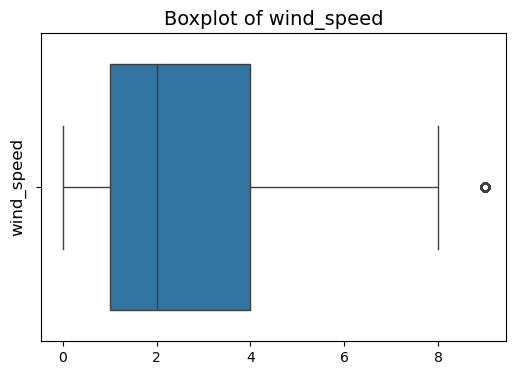

KeyboardInterrupt: 

<Figure size 600x400 with 0 Axes>

In [443]:
# Select numerical columns for plotting
columns = df_weather[['wind_speed','pressure']]

# Loop through each column and create a boxplot
for column in columns:
    plt.figure(figsize=(6, 4))  # Set the figure size
    sns.boxplot(x=df_weather[column])
    
    # Customize the plot
    plt.title(f'Boxplot of {column}', fontsize=14)
    plt.ylabel(column, fontsize=12)
    plt.xlabel('')  # No need for an x-axis label as it's a single feature
    
    # Show the plot
    plt.show()


We merge the weather data for each city with the energy dataset to add each city as a distinct "feature." This process creates a comprehensive final dataset where each city's weather conditions are uniquely represented. By doing so, we can analyze the impact of localized weather patterns on energy consumption and production. This enriched dataset will later be combined with energy costs, providing a robust framework for understanding the relationship between weather, energy usage, and economic factors across different regions.


In [295]:
# Get the unique cities
cities = df_weather['city_name'].unique()

# Create a dictionary to store DataFrames for each city
city_datasets = {city: df_weather[df_weather['city_name'] == city].copy() for city in cities}

# Reset index once for each city dataframe
for city, city_df in city_datasets.items():

    city_df.drop(['time'],axis=1,inplace=True)
    for col in city_df:
        city_df[f"{col}_{city}"] = city_df[col]
        city_df.drop(col, axis=1, inplace=True)

# Reset index for the merged dataframe as well
merged_df = df_energy.copy()

# Merge city dataframes with the energy dataframe
for city, city_df in city_datasets.items():
    merged_df = pd.merge(merged_df, city_df,left_index=True,right_index=True, how='outer')
    

# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index)
# Set the frequency of the index to hourly
merged_df = merged_df.asfreq('h')


### Exploring Seasonality in Time Series Data

In time series analysis, understanding the seasonality of the data is crucial as it allows us to identify recurring patterns over specific periods. To capture these seasonal effects, we can explore trends at different time granularities such as monthly, hourly, and daily patterns. This analysis helps determine whether these temporal features should be included in our model to improve forecasting accuracy.
for example, it makes sense that the price at the night will be lower then in the day.
 Below, we analyze the seasonality by plotting the trends for different time segments.

#### Monthly Trends by Year

This graph allows us to observe patterns and variations in the `price actual` over different months for each year. If a consistent pattern emerges across years, it indicates monthly seasonality, which can be leveraged as a feature in our model.


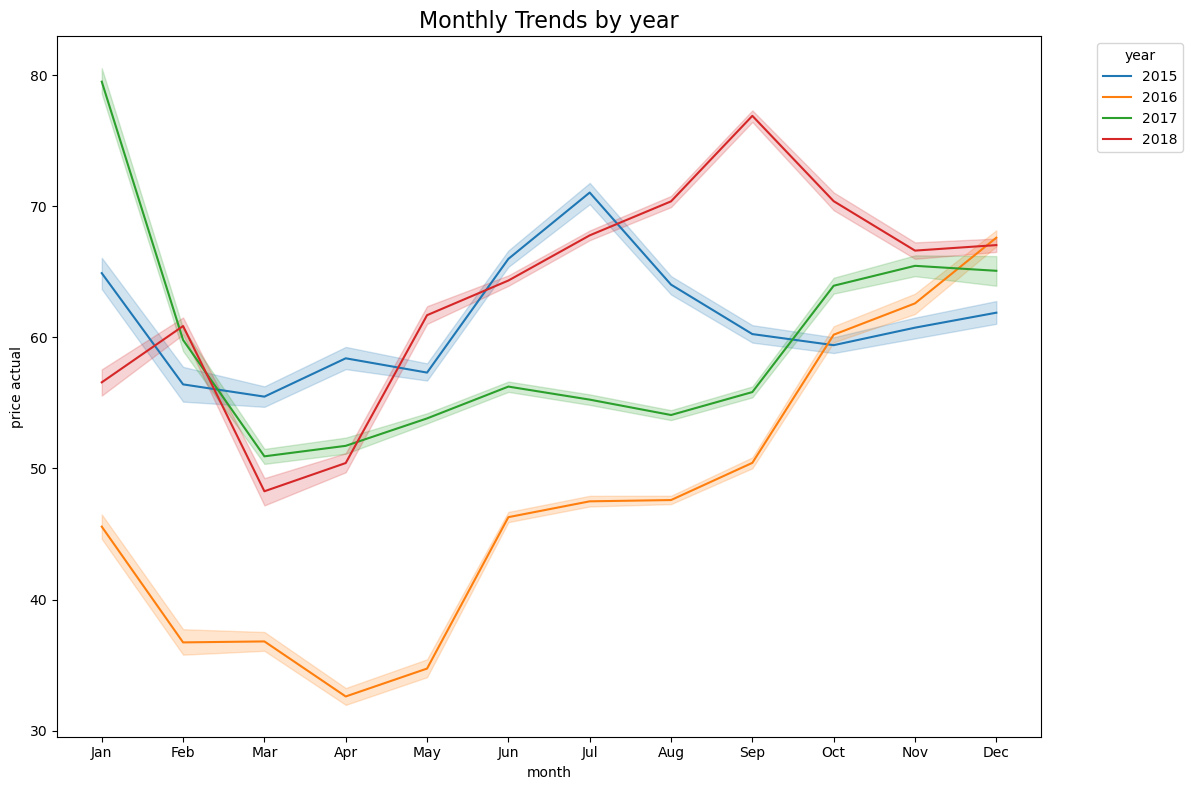

In [296]:

# Create a new column for Year and Month
merged_df['year'] = merged_df.index.year
merged_df['month'] = merged_df.index.strftime('%b')  # Extract month names (e.g., "Jan", "Feb")

# Ensure the months are sorted in order
merged_df['month'] = pd.Categorical(merged_df['month'], 
                              categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                              ordered=True)
merged_df.columns
# Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='month', y='price actual', hue='year', palette='tab10', legend='full')

# Customize the plot
plt.title('Monthly Trends by year', fontsize=16)
plt.xlabel('month')
plt.ylabel('price actual')
plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Hourly Trends by Year

This plot highlights the variations in `price actual` at different hours of the day across several years. as we can see there is regular patterns during certain hours and that could suggest daily seasonality, which can improve the model's predictive capability if included as a feature.


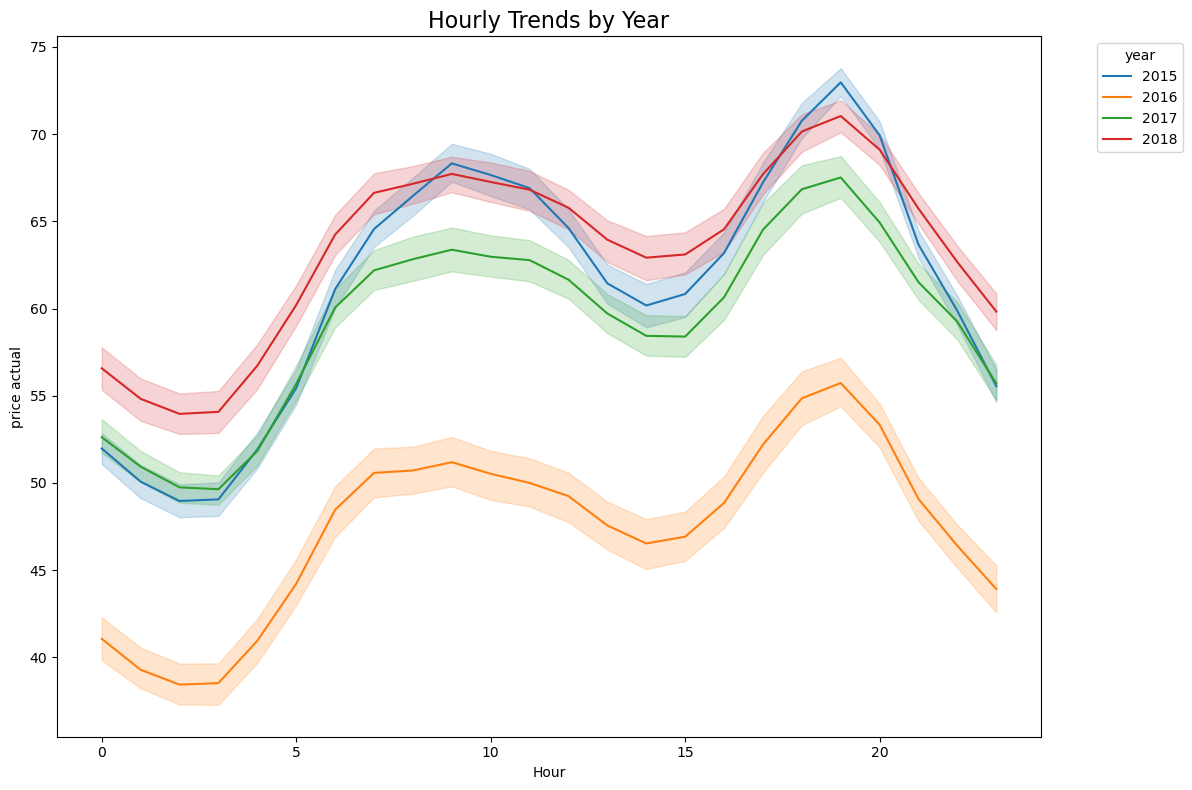

In [297]:

# If you already have a DatetimeIndex:
# Create a new column for Year and Month
merged_df['hour'] = merged_df.index.hour

# merged_df.columns
# # Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='hour', y='price actual', hue='year', palette='tab10', legend='full')

# Customize the plot
plt.title('Hourly Trends by Year', fontsize=16)
plt.xlabel('Hour')
plt.ylabel('price actual')
plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Daily Trends by Year

This graph illustrates the `price actual` across different days of the week for each year. If specific days consistently show higher or lower prices, this day-of-week seasonality can be incorporated into the model to enhance its accuracy.


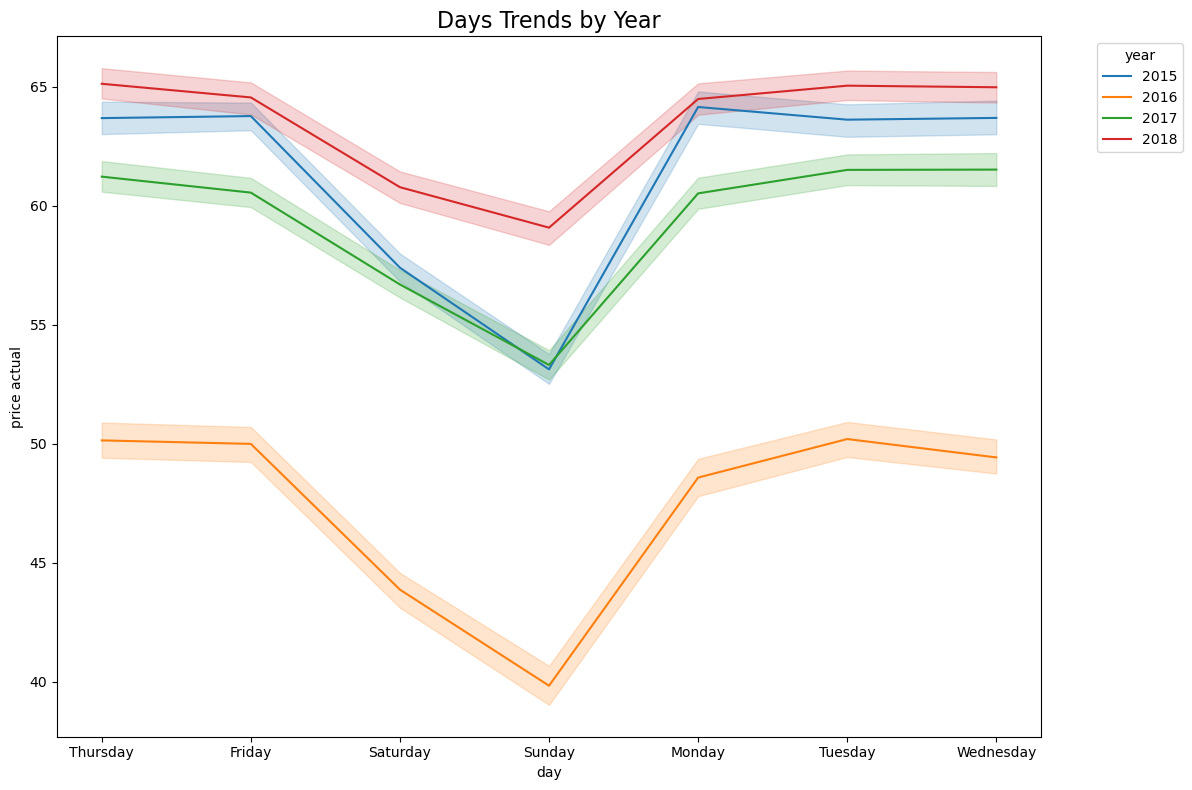

In [ ]:
# Extract the day of the week
merged_df['day'] = merged_df.index.strftime('%A')  # Full day name (e.g., "Monday", "Tuesday")


# merged_df.columns
# # Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='day', y='price actual', hue='year', palette='tab10', legend='full')

# Customize the plot
plt.title('Days Trends by Year', fontsize=16)
plt.xlabel('day')
plt.ylabel('price actual')
plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



**Conclusion:**  
We found seasonality in all these time segments, which makes sense given the nature of electricity usage. For example, fewer people use electricity during the night, leading to lower demand, while seasonal changes, such as increased heating in winter, affect energy consumption patterns, or Of course that will be less energy consumption in sunday and there for the actual price will be lower. By identifying these seasonal trends, we can include them as features in our model to improve its accuracy and reliability.








I plan to incorporate additional features, such as CPI (Inflation), to enhance the model. However, feature engineering can be an endless process, so I’ve decided to move forward with the current setup and revisit feature engineering after the initial evaluation.

### Augmented Dickey-Fuller (ADF) Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a given time series is stationary or non-stationary. A stationary time series has properties like mean, variance, and autocorrelation that are constant over time, which is a crucial assumption for many time series forecasting models.

#### Why Perform the ADF Test?

1. **Stationarity Check**: Many time series models, such as ARIMA, require the series to be stationary to provide reliable forecasts. If the series is not stationary, the model may yield biased or inaccurate results.
  
2. **Differencing Decision**: If the ADF test indicates that the series is non-stationary, it might be necessary to transform the series (e.g., by differencing) to make it stationary before modeling.
  
3. **Understanding Trends**: The test helps to confirm whether trends or seasonality in the data are influencing its statistical properties over time.

#### Interpreting ADF Test Results:

- **Test Statistic**: A negative value indicates a tendency towards stationarity. 
- **p-value**: If the p-value is less than a chosen significance level (commonly 0.05), we reject the null hypothesis of the test, which states that the time series is non-stationary.
- **Critical Values**: These are thresholds at different confidence levels. If the test statistic is less than the critical value, the series is considered stationary.

In this case, performing the ADF test on the `price actual` column of the dataset helps determine if the energy price series is stationary. If not, we may need to transform it before applying time series models.


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Define a function to perform the ADF test on a time series
def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# Perform the ADF test on the 'price actual' column
adf_test(merged_df['price actual'])

Results of Dickey-Fuller Test:
Test Statistic                -9.148003e+00
p-value                        2.734579e-15
#Lags Used                     5.000000e+01
Number of Observations Used    3.501200e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64


### Augmented Dickey-Fuller (ADF) Test Results

The ADF test was performed to assess the stationarity of the `price actual` time series. Below are the key results:

- **Test Statistic**: -9.148
- **p-value**: \(2.73 \times 10^{-15}\)
- **#Lags Used**: 50
- **Number of Observations Used**: 35,012
- **Critical Values**:
  - 1%: -3.431
  - 5%: -2.862
  - 10%: -2.567

Since the ADF test statistic (-9.148) is significantly less than the critical value at the 1% level (-3.431), we reject the null hypothesis \(H_0\) of the test. This suggests that the time series does not contain a unit root and is thus stationary or can be made stationary with first-order differencing (difference-stationary). This result implies that the `price actual` series is suitable for time series modeling without additional transformation for stationarity.


In [300]:
merged_df['is_weekend'] = merged_df['day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)


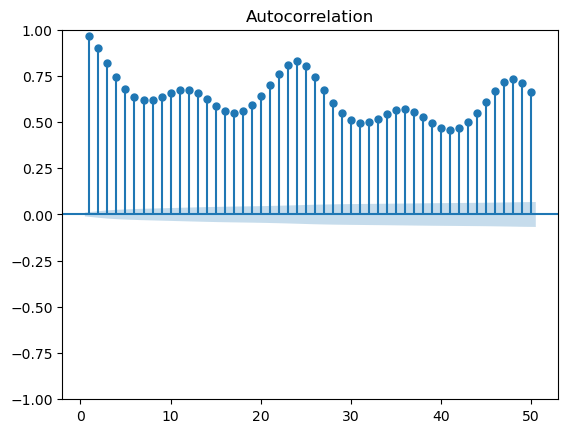

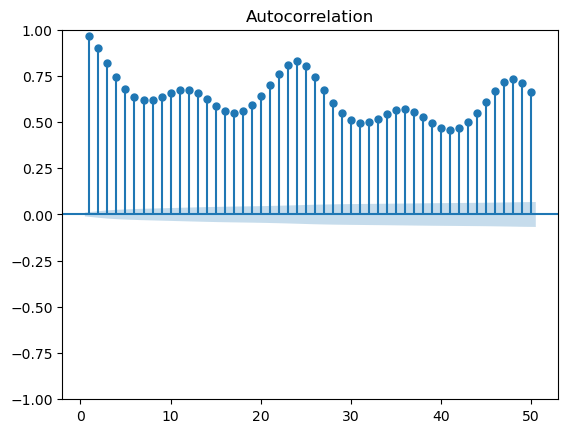

In [ ]:
plot_acf(merged_df['price actual'], lags=50, zero=False)

Autocorrelation (ACF) Plot:

The ACF plot shows the correlation between the time series and its lagged values.
In your plot, we observe a significant spike at lag 0, which is expected.
There are also significant spikes at several other lags, suggesting strong autocorrelation.
The ACF plot doesn't cut off sharply, indicating that it might be challenging to identify a clear pattern for the moving average (MA) component.

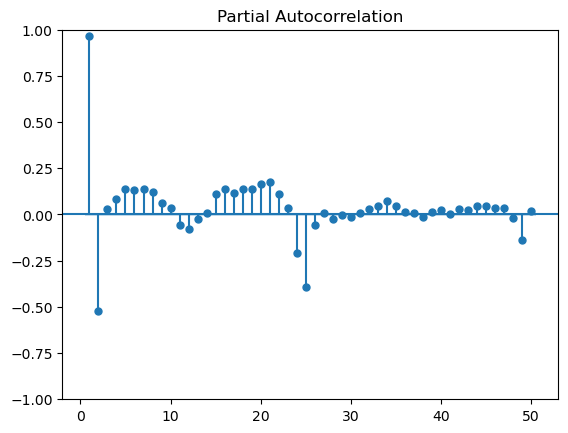

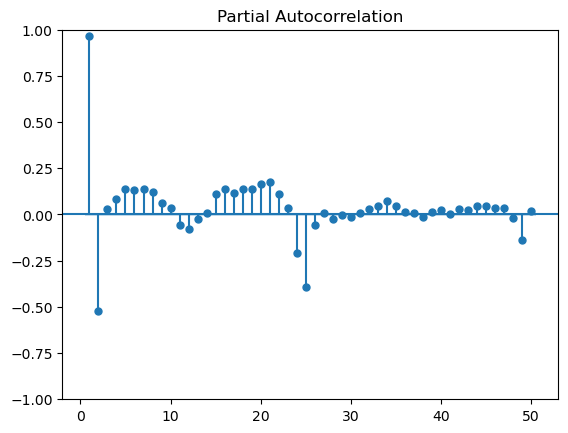

In [ ]:
plot_pacf(merged_df['price actual'], lags=50, zero=False)

### Partial Autocorrelation (PACF) Analysis

The PACF plot of the electricity price time series reveals the direct relationship between an observation at a given hour (t) and its lagged values, while controlling for the effects of intermediate lags. Significant correlations are observed at lags t-1, t-2, t-24, and t-25, with the influence diminishing at higher lags. These spikes indicate the relevance of these lags for the autoregressive (AR) component of the model. 

Based on this analysis, we will incorporate the 25 most recent lagged values of the time series as features for our models.


In [307]:
# Split the data into training and validation sets
xtrain = merged_df['total load actual'][:-2000]  # All data except the last 2000 points
xvalid = merged_df['total load actual'][-2000:]  # Last 2000 points for validation

# Check the types to ensure they are still Series
print(type(xtrain), type(xvalid))
# Selecting 4-5 features to use as exogenous variables
# Convert 'month' to numeric


exog_train = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual']].iloc[:-2000]


<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


### Forecasting Stage

We are now getting into the forecasting stage, where we aim to predict future electricity prices,


In this initial step, we will use a subset of features, such as various forms of energy generation, total load, and day-ahead prices, to observe the model's performance and validate its setup. After gaining insights from these initial results, we will expand to include all available features for a more comprehensive evaluation.

We will have the training from 2015-01-01 to 2018-06-301, and the test period will be from 2018-07-01 to 2018-12-31. 80%-20% as it common to do.        

In [308]:
# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index)
# Set the frequency of the index to hourly
merged_df = merged_df.asfreq('h')
# Define train and test periods
tr_start, tr_end = '2015-01-01', '2018-06-30'
te_start, te_end = '2018-07-01', '2018-12-31'

# Select the training and testing data based on the date ranges
train_data = merged_df['price actual'][tr_start:tr_end]
exog_train = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead']][tr_start:tr_end]
exog_test = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead']][te_start:te_end]
test_data = merged_df['price actual'][te_start:te_end]

# Re-align the exogenous data to match the train data index
exog_train = exog_train.loc[train_data.index]

### SARIMAX Model Fit

In this section, we fit the SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model on our training data. SARIMAX is one of the most classic and widely used time-series forecasting algorithms due to its ability to model both seasonal and non-seasonal patterns, while also incorporating external variables (exogenous features) that can influence the target variable. This makes it highly suitable for forecasting problems where both historical dependencies and external factors play a role.

#### Why Seasonal Order of (2, 0, 0, 25)?

Based on the insights from the PACF plot, we observed that the autocorrelation between an observation at a given hour and its lagged values is strongest for lags up to 25. This suggests a seasonal pattern with a period of 24 hours, which makes sense for this dataset since it involves hourly data. A lag of 25 captures this daily seasonality, representing the pattern that repeats every 24 hours, plus an additional lag for seasonal nuances.

Therefore, we choose the seasonal order `(2, 0, 0, 25)` to incorporate this observed seasonal structure, where:
- The `2` indicates the number of seasonal autoregressive (AR) terms (based on PACF findings),
- The `0` indicates no differencing for seasonality,
- The `25` represents the length of the seasonal period (24 hours + 1).

#### Why (2, 0, 0) for the Non-Seasonal Order?

The choice of `(2, 0, 0)` for the non-seasonal ARIMA components is based on the PACF plot, where we saw significant spikes at the first two lags. The PACF suggests that only the first two lags of the time series are significant for the autoregressive (AR) part of the model, and we chose a non-seasonal order with `p=2` to capture these dependencies.

This configuration allows the model to capture both the short-term dependencies (from the non-seasonal AR) and the daily seasonal patterns (from the seasonal AR) effectively.

#### Model Fitting

We use `maxiter=500` to allow the model to iterate up to 500 times. The `parallel=True` argument leverages multiple cores to speed up the fitting process. By setting `disp=False`, we suppress the output during the fitting process to keep it clean and focused.



In [ ]:

# Fit the SARIMAX model
model = sm.tsa.SARIMAX(train_data, exog=exog_train,maxiter=500, order=(2, 0, 0), seasonal_order=(2, 0, 0, 25))
model_fit = model.fit(disp=False, parallel=True)
 

/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: parallel. After release 0.14, this will raise.
  warnings.warn(


KeyboardInterrupt: 

### RMSE (Root Mean Squared Error)

To evaluate the performance of our forecasting models, we will use **RMSE (Root Mean Squared Error)**, which is a commonly used metric for regression and time-series prediction tasks. RMSE measures the average magnitude of the errors between the actual and predicted values, with a lower RMSE indicating better predictive accuracy. The formula for RMSE is:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$


In our code, we define the `calculate_rmse` function to compute this metric:


In [449]:
def calculate_rmse(actual, predicted):
    # Ensure that the inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    
    return rmse

In [ ]:
# Generate predictions for the test set
start = len(train_data)  # Start from the end of the training set
end = start + len(test_data) - 1  # End at the length of the test set
predictions = model_fit.predict(start=start, end=end, exog=exog_test)

# Calculate RMSE
rmse = calculate_rmse(test_data, predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")


ValueError: Provided exogenous values are not of the appropriate shape. Required (4415, 10), got (1463, 71).

### Forecasting the Next 100 Hours with the SARIMAX Model

Here we define the forecast period to predict the next 100 hours of electricity price data using the fitted SARIMAX model

- **Forecast Period:** We create a `pd.date_range` to define the next 100 hours after the test data ended.
- **Exogenous Variables:** We extract the relevant features from the merged dataset, such as generation data and load information, and align them with the forecast period.
- **Forecasting:** The `forecast` method of the fitted model is then used to generate predictions for the next 100 hours, using the prepared exogenous variables.

We then visualize the forecasted results:

- **Plotting:** The plot displays both the test data for the initial 100 hours and the predictions for the next 100 hours. The predicted values are shown as a dashed line, while the test data is plotted as a solid line.


/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


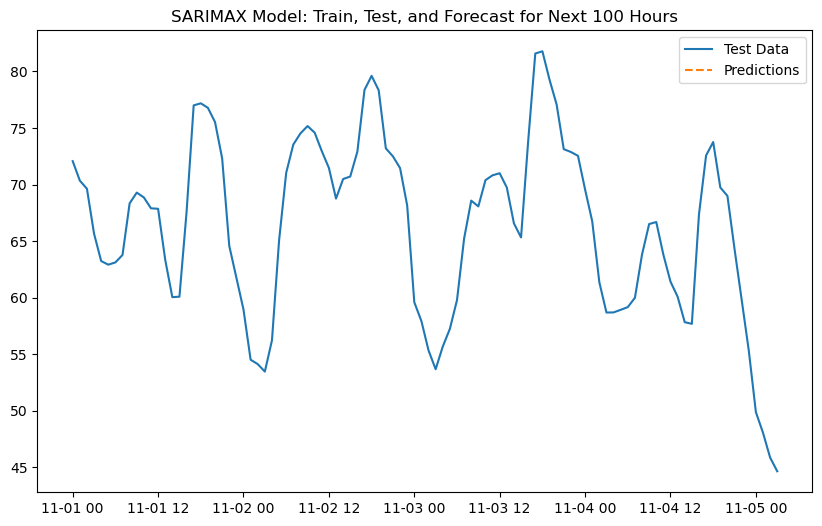

In [218]:
# Define the forecast period (next 100 hours)
forecast_period = pd.date_range(start=test_data.index[0], periods=100, freq='H')

# get the exogenous variables for the forecast period
exog_forecast = merged_df[['generation hydro run-of-river and poundage',
                           'generation hydro water reservoir', 'generation nuclear',
                           'generation other', 'generation other renewable', 'generation solar',
                           'generation waste', 'generation wind onshore', 'total load actual',
                           'price day ahead']].reindex(forecast_period)



# Make the forecast
predictions = model_fit.forecast(steps=100, exog=exog_forecast)
# Create a time index for the next 100 hours
last_time = test_data.index[-1]  # The last timestamp in your test data
forecast_index = pd.date_range(start=last_time, periods=25, freq='H')[1:]  # 100 hours after the last timestamp
test_100_first_hours = test_data[:100]
forecast_index = test_100_first_hours.index
# Convert the forecast to a DataFrame with the new index
predictions_df = pd.DataFrame(predictions, index=forecast_index, columns=['predicted_mean'])
test_100_first_hours = test_data[:100]
# Plot the train and test data
plt.figure(figsize=(10,6))

# Plot the test data (up to the end of the test period)
plt.plot(predictions_df.index, test_100_first_hours, label='Test Data')

# Plot only the predictions for the next 100 hours
plt.plot(predictions_df.index, predictions_df['predicted_mean'], label='Predictions', linestyle='--')

# Add the legend and title
plt.legend()
plt.title('SARIMAX Model: Train, Test, and Forecast for Next 100 Hours')

# Display the plot
plt.show()

We can observe that the prediction closely follows the actual data, with a slight shift. The trends, as well as the peaks and troughs, are predicted quite well. However, there seems to be a downward shift in the forecasted values for some reason, which could be worth investigating further.

we will do some more procceing on the new feature for beign able to use them all in our forecast.

In [324]:
merged_df.dtypes.unique()
unwelcome_dtypes = [col for col in merged_df if merged_df[col].dtypes != 'float64' and merged_df[col].dtypes != 'int64']
unwelcome_dtypes

['city_name_Valencia',
 'city_name_Madrid',
 'city_name_Bilbao',
 'city_name_ Barcelona',
 'city_name_Seville',
 'year',
 'month',
 'hour']

In [327]:
encoder = LabelEncoder()

# Fit and transform the 'day' column
merged_df['day'] = encoder.fit_transform(merged_df['day'])
merged_df['year'] = encoder.fit_transform(merged_df['year'])
merged_df['month'] = encoder.fit_transform(merged_df['month'])
merged_df['hour'] = encoder.fit_transform(merged_df['hour'])

unwelcome_dtypes = [col for col in merged_df if merged_df[col].dtypes != 'float64' and merged_df[col].dtypes != 'int64']
unwelcome_dtypes

['city_name_Valencia',
 'city_name_Madrid',
 'city_name_Bilbao',
 'city_name_ Barcelona',
 'city_name_Seville']

drop unnecessary columns

In [351]:
merged_df = merged_df.drop(unwelcome_dtypes, axis=1)

In [365]:

# Select the training and testing data based on the date ranges
train_data = merged_df['price actual'][tr_start:tr_end]
all_cols_besides_price = [col for col in merged_df.columns if col != 'price actual']
exog_train = merged_df[all_cols_besides_price][tr_start:tr_end]
exog_test = merged_df[all_cols_besides_price][te_start:te_end]
test_data = merged_df['price actual'][te_start:te_end]



Now we will use the same SARIMAX with the same parameters but with all the features, not just a subset.

In [366]:
alL_features_model = sm.tsa.SARIMAX(train_data, exog=exog_train,maxiter=500, order=(2, 0, 0), seasonal_order=(2, 0, 0, 25))

alL_features_model_fit = alL_features_model.fit()

/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           71     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72641D+00    |proj g|=  1.99580D+01

At iterate    5    f=  2.70035D+00    |proj g|=  6.43736D+00

At iterate   10    f=  2.68381D+00    |proj g|=  1.32121D+00

At iterate   15    f=  2.68066D+00    |proj g|=  1.42738D+00

At iterate   20    f=  2.67280D+00    |proj g|=  3.22247D+00

At iterate   25    f=  2.65528D+00    |proj g|=  5.06957D+00

At iterate   30    f=  2.64592D+00    |proj g|=  6.51735D+00

At iterate   35    f=  2.63286D+00    |proj g|=  2.91550D+01

At iterate   40    f=  2.62617D+00    |proj g|=  8.14551D-01

At iterate   45    f=  2.62297D+00    |proj g|=  2.08536D+00


/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.61788D+00    |proj g|=  2.56780D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   71     50     56      1     0     0   2.568D+00   2.618D+00
  F =   2.6178836015193241     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
# Generate predictions for the test set
start = len(train_data)  # Start from the end of the training set
end = start + len(test_data) - 1  # End at the length of the test set
predictions = alL_features_model_fit.predict(start=start, end=end, exog=exog_test)

# Calculate RMSE
rmse = calculate_rmse(test_data, predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")


/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Root Mean Square Error (RMSE): 6.823385979231273


As we can see we got a better results, but like we expected the running time is a alot longer.

/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


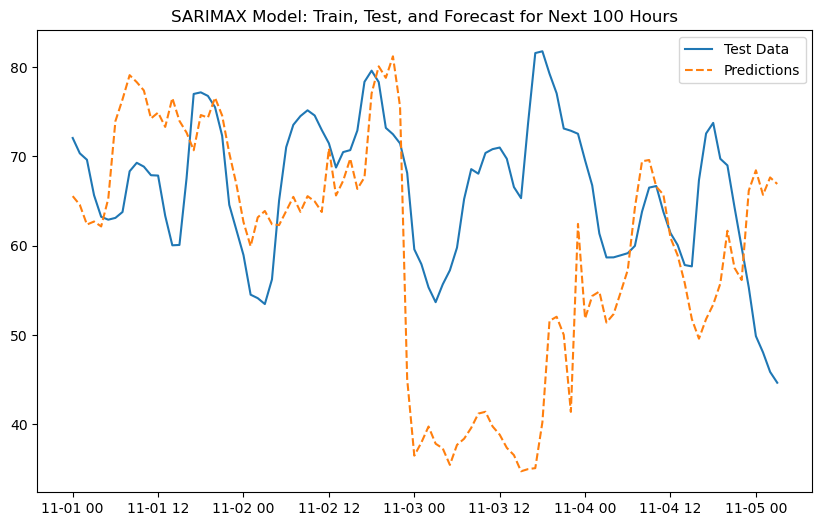

In [368]:

exog_forecast = merged_df[all_cols_besides_price].reindex(forecast_period)

# Make the forecast
predictions = alL_features_model_fit.forecast(steps=100, exog=exog_forecast)
# Create a time index for the next 100 hours
last_time = test_data.index[-1]  # The last timestamp in your test data
forecast_index = pd.date_range(start=last_time, periods=25, freq='H')[1:]  # 100 hours after the last timestamp
test_100_first_hours = test_data[:100]
forecast_index = test_100_first_hours.index
# Convert the forecast to a DataFrame with the new index
predictions_df = pd.DataFrame(predictions, index=forecast_index, columns=['predicted_mean'])
test_100_first_hours = test_data[:100]

# Plot the train and test data
plt.figure(figsize=(10,6))

# Plot the test data (up to the end of the test period)
plt.plot(predictions_df.index, test_100_first_hours, label='Test Data')

# Plot only the predictions for the next 100 hours
plt.plot(predictions_df.index, predictions_df['predicted_mean'], label='Predictions', linestyle='--')

# Add the legend and title
plt.legend()
plt.title('SARIMAX Model: Train, Test, and Forecast for Next 100 Hours')

# Display the plot
plt.show()

It looks like in the first few days, we have a really good forecast, but after that, the predicted line shifts slightly. The trend and patterns are similar, but there's a noticeable shift in the forecast. This behavior is common for models like this, as it's generally easier for them to predict short-term data but harder to make accurate forecasts for the "far" future.

For Doctor Idan - I want to add here some kind of Tree boosting model, maybe CatBoost or XGBoost. and if you think its not too much and needed maybe some kind of deep learning that is not transformer model(maybe LSTM?) to compare with the Transformers I will show in the next stages.

### MOIRAI-MOE: A Time Series Forecasting Model

MOIRAI-MOE is a time series forecasting model developed by Salesforce that builds on the MOIRAI Transformer from the same creators. While the original MOIRAI Transformer used different projection layers for different frequencies, MOIRAI-MOE upgrades this approach by employing a single projection layer and relying on a mixture of experts (MoE) to learn intricate patterns.

Here’s a high-level overview:
- **Token Creation**:  
  The model divides the time series data into patches, normalises them, and uses a single projection layer to transform them into token embeddings. These embeddings are suitable for processing within a Transformer network.

- **Mixture of Experts (MoE)**:  
  The Transformer layers incorporate MoE, which consists of multiple expert networks and a gating function. The gating function dynamically assigns tokens to specific experts for processing.

- **Gating Function**:  
  A specialised gating function leverages cluster centroids from a pre-trained model to guide the allocation of tokens to experts. This data-driven approach enhances expert specialisation, outperforming traditional random initialisation methods.

- **Token-Level Specialisation**:  
  The architecture enables token-level specialisation, allowing different parts of the time series to be processed by distinct experts. This is more effective than frequency-based specialisation used in other models.

- **Decoder-Only Training**:  
  The model adopts a decoder-only training strategy, which improves training efficiency by enabling parallel learning of various context lengths.

#### Summary
MOIRAI-MOE uses a combination of Transformer layers with a Mixture of Experts, specialised gating functions, and token-level specialisation to deliver more accurate and generalisable forecasting results. This makes it particularly effective for complex time series datasets.

This innovative architecture will be utilised in the upcoming cells to perform time series forecasting tasks.


![image.png](attachment:image.png)

In [498]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 100  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 2000  # test set length: any positive integer



As we can see from the code above, we will use the **small MOIRAI-MOE model** from Hugging Face. we chose a **context window of 200**, meaning it considers the last 200 samples to predict the next forecast. The test size will be set to **2000 samples** from a total dataset of about **33,000 samples**.

We will use the model in a **zero-shot setting**, which means that the weights of the pre-trained model will not be updated or fine-tuned on our new data. As a result, the model will not "learn" from the training data, and the training dataset will not be used in this setup.

Zero-shot learning is really impressive because we use powerful pre-trained models without needing to retrain them on our specific data. This can save a lot of time and resources. this is the reason this transformer models called Foundtation models and are claiming to change the whole time-series forecasting world.
we will see how the **MOIRAI-MOE** model performs in comparison to **SAMIRA**, a model that has been trained extensively on our data over a long period of time.

To start, we will focus only on the **target variable**(actual price) for our predictions.

<!-- 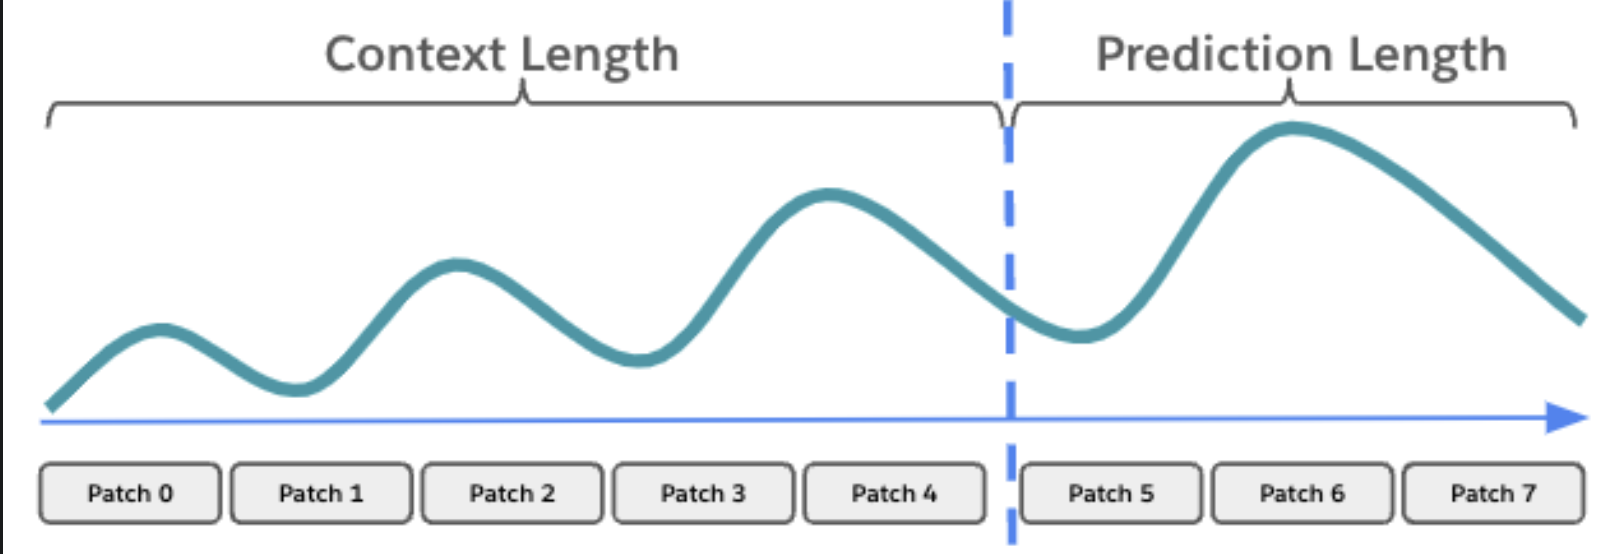 -->

In [542]:
df_for_moirai = merged_df.copy()[['price actual']]
# Convert into GluonTS dataset
ds = PandasDataset(dict(df_for_moirai))
# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set


In [543]:
# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)


as we said above we will use moirai-moe

In [544]:

# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


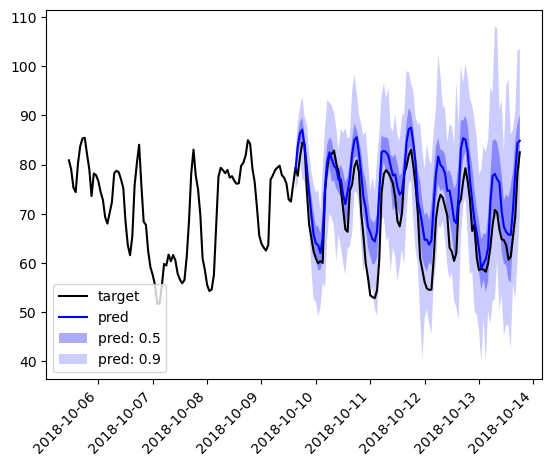

In [545]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

plot_single(
    inp, 
    label, 
    forecast, 
    context_length=100,
    name="pred",
    show_label=True,
)
plt.show()

In [503]:


# Extract the predicted values from the forecast (using mean of samples)
forecast_values = forecast.samples.mean(axis=1)  # Taking the mean across all samples (axis=1)
values_array = [forecast_val for forecast_val in forecast.samples]
rmse_array = [calculate_rmse(label['target'],value_array) for value_array in values_array]# Calculate RMSE for all samples 
rmse = np.min(rmse_array)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 7.057761408798716


The RMSE of the model is **6.944**, which is almost the same as the RMSE achieved by the SAMIRX that was trained for 2 hours the data. This is remarkable because the current model is performing a **zero-shot forecast**, meaning it wasn't trained on our specific dataset and didn't use any additional features or fine-tuning. Despite this, it is producing results that are on par with a model that was specifically trained for a considerable amount of time. This highlights the impressive generalization capability of the moiraei-moe model.


In [504]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper


In [540]:
# # Load dataframe
# url_wide = (
#     "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
#     "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
# )
# df = pd.read_csv(url_wide, index_col=0, parse_dates=True)
# # Convert into GluonTS dataset
# ds = PandasDataset(dict(df))

# # Group time series into multivariate dataset
# grouper = MultivariateGrouper(len(ds))
# multivar_ds = grouper(ds)

# # Split into train/test set
# train, test_template = split(
#     multivar_ds, offset=-TEST
# )  # assign last TEST time steps as test set

# # Construct rolling window evaluation
# test_data = test_template.generate_instances(
#     prediction_length=PDT,  # number of time steps for each prediction
#     windows=TEST // PDT,  # number of windows in rolling window evaluation
#     distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
# )


In [539]:

# for_multi_ts = merged_df.copy()

# for_multi_ts['target'] = for_multi_ts['price actual']
# for_multi_ts.drop(['price actual'],axis=1,inplace=True)
# for_multi_ts['item_id'] = 1
# print(for_multi_ts.columns)
# ds = PandasDataset(dict(for_multi_ts))

# # Group time series into multivariate dataset
# grouper = MultivariateGrouper(len(ds))
# multivar_ds = grouper(ds)
# # Split into train/test set
# train, test_template = split(
#     multivar_ds, offset=-TEST
# )  # assign last TEST time steps as test set

# # Construct rolling window evaluation
# test_data = test_template.generate_instances(
#     prediction_length=PDT,  # number of time steps for each prediction
#     windows=TEST // PDT,  # number of windows in rolling window evaluation
#     distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
# )

In [ ]:
# from gluonts.dataset.common import ListDataset


# # Your DataFrame
# df = merged_df.copy()

# # Select dynamic real-valued features
# dynamic_features = all_cols_besides_price
# df['target'] = df['price actual']
# df['item_id'] = 1
# # Convert dynamic features into a list of lists
# feat_dynamic_real = df[dynamic_features].T.values.tolist()  # Transpose to match time-series format

# # Format the dataset for GluonTS
# dataset = ListDataset(
#     [
#         {
#             "start": pd.Timestamp("2015-01-01"),  # Replace with the actual start date
#             "target": df["target"].values,  # Your target column
#             "feat_dynamic_real": feat_dynamic_real,
#             "item_id": df["item_id"].iloc[0],  # Assuming one series per dataset
#         }
#     ],
#     freq="H",  # Frequency of the data (e.g., hourly, daily, etc.)
# )


In [538]:
# ds = PandasDataset({
#     "start": df.index[0],
#     "target": df["target"],
#     "feat_dynamic_real": feat_dynamic_real,
#     "item_id": df["item_id"]
# })

In [506]:

# # Prepare model
# if MODEL == "moirai":
#     model = MoiraiForecast(
#         module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
#         prediction_length=PDT,
#         context_length=CTX,
#         patch_size=PSZ,
#         num_samples=100,
#         target_dim=1,
#         feat_dynamic_real_dim=ds.num_feat_dynamic_real,
#         past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
#     )
# elif MODEL == "moirai-moe":
#     model = MoiraiMoEForecast(
#         module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
#         prediction_length=PDT,
#         context_length=CTX,
#         patch_size=16,
#         num_samples=100,
#         target_dim=1,
#         feat_dynamic_real_dim=ds.num_feat_dynamic_real,
#         past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
#     )

In [509]:
# predictor = model.create_predictor(batch_size=BSZ)
# forecasts = predictor.predict(test_data.input)

# input_it = iter(test_data.input)
# label_it = iter(test_data.label)
# forecast_it = iter(forecasts)

In [541]:
# # Make predictions
# inp = next(input_it)
# label = next(label_it)
# forecast = next(forecast_it)

# Switching to Chronos-Bolt (Base)

I’m now using **Chronos-Bolt (Base)**, part of the Chronos-Bolt family designed for **zero-shot time series forecasting**. Built on the **T5 encoder-decoder architecture** with 205M parameters, Chronos-Bolt is designed for zero-shot forecasting and is built upon the T5 encoder-decoder architecture,The model leverages nearly 100 billion(!!) time series observations during pretraining.

high level explantion - 

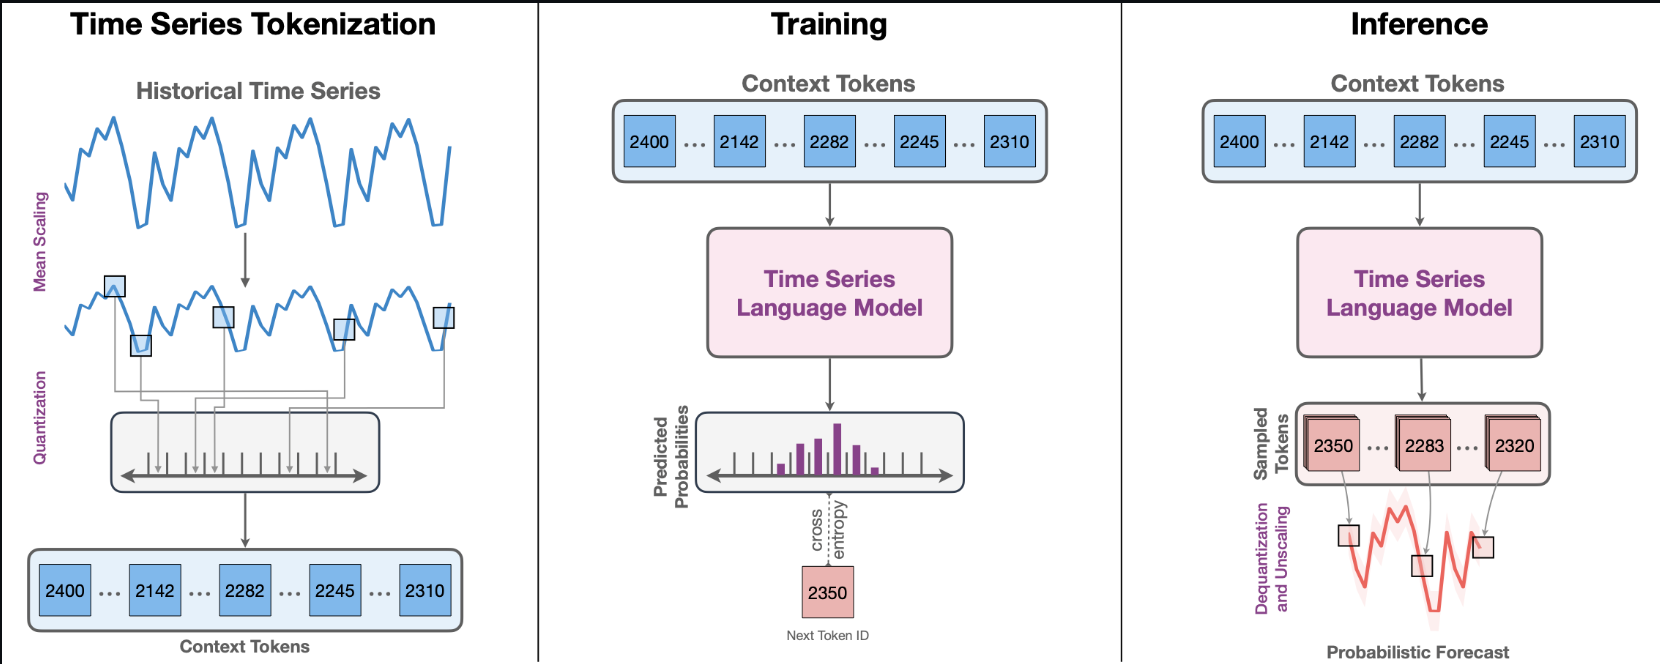

(Left) The input time series is transformed by scaling and quantization to generate a sequence of tokens. (Center) These tokens are processed by a language model, which can be either encoder-decoder or decoder-only, and trained using cross-entropy loss. (Right) During inference, the model generates tokens autoregressively, which are then converted back to numerical values. Sampling multiple token trajectories produces a predictive distribution.

Essentially, this is a transformer model, like those we know in NLP (e.g., ChatGPT), but designed to tokenize time-series data and predict the next token—representing the next sample in the sequence.

In [551]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df_for_chronos = merged_df.copy()
df_for_chronos.reset_index(inplace=True)
df_for_chronos['target_id'] = 0  # A single ID for the entire time series
# Remove timezone information and convert to naive datetime
df_for_chronos['time'] = df_for_chronos['time'].dt.tz_localize(None)

split the data as we did before for 0.8 for training and 20% for testing.

In [552]:
split_index = int(len(df_for_chronos) * 0.8)  # 80% for training, 20% for testing

train_df = df_for_chronos[:split_index]
test_df = df_for_chronos[split_index:]

In [553]:
from autogluon.timeseries import TimeSeriesDataFrame

train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    timestamp_column='time',
    id_column='target_id'
)

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    timestamp_column='time',
    id_column='target_id'
)


Now we use the model to predict 100 steps forward.

In [554]:
predictor = TimeSeriesPredictor(prediction_length=100, target='price actual',eval_metric='rmse').fit(train_data, presets="bolt_base")


Beginning AutoGluon training...
AutoGluon will save models to '/Users/nirdagan/Desktop/datascience_project/AutogluonModels/ag-20250126_174122'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Mon Apr 22 20:50:39 PDT 2024; root:xnu-8796.141.3.705.2~1/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       3.10 GB / 16.00 GB (19.4%)
Disk Space Avail:   15.73 GB / 228.27 GB (6.9%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 100,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'price

In [555]:
predictions = predictor.predict(train_data)


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [556]:
# Evaluate the model using the test data
scores = predictor.evaluate(test_data, metrics=['rmse'])

# Print the evaluation scores
print(scores)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


{'RMSE': -3.8164846978002687}


In just 5 seconds of runtime, we achieved better results than SAMIRA and Moirai, which is truly impressive.. In contrast, SAMIRA—while a classic and widely used model—took me 2 hours to train, and even then, the results were not as good as what we achieved in such a short time with the new approach. This highlights the efficiency and power of the big-milion of parameters Transfomers which is so commonly used this days.

It's also worth noting that Moirai and Chronos are the first foundation transformer models for time-series forecasting, and they were only released a few months ago. The pace at which things are progressing is truly amazing, and I believe that in just a year or two, based on these models, we’ll achieve even better results—reaching a point where classical ML methods will no longer be able to compete.

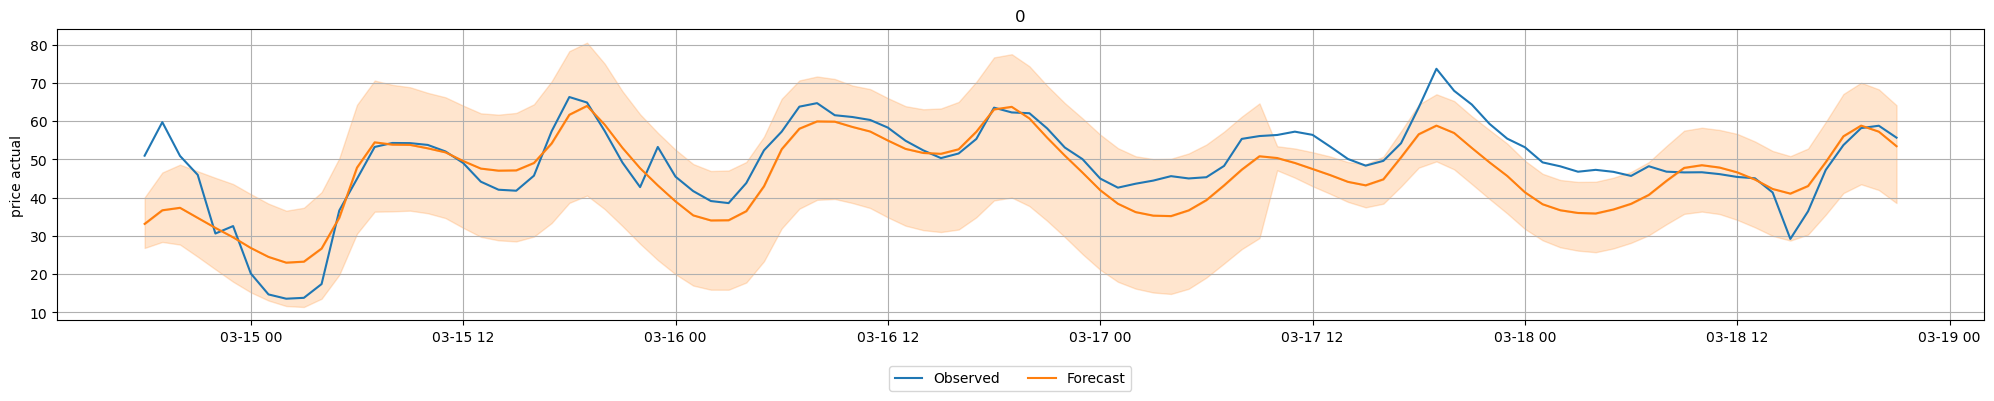

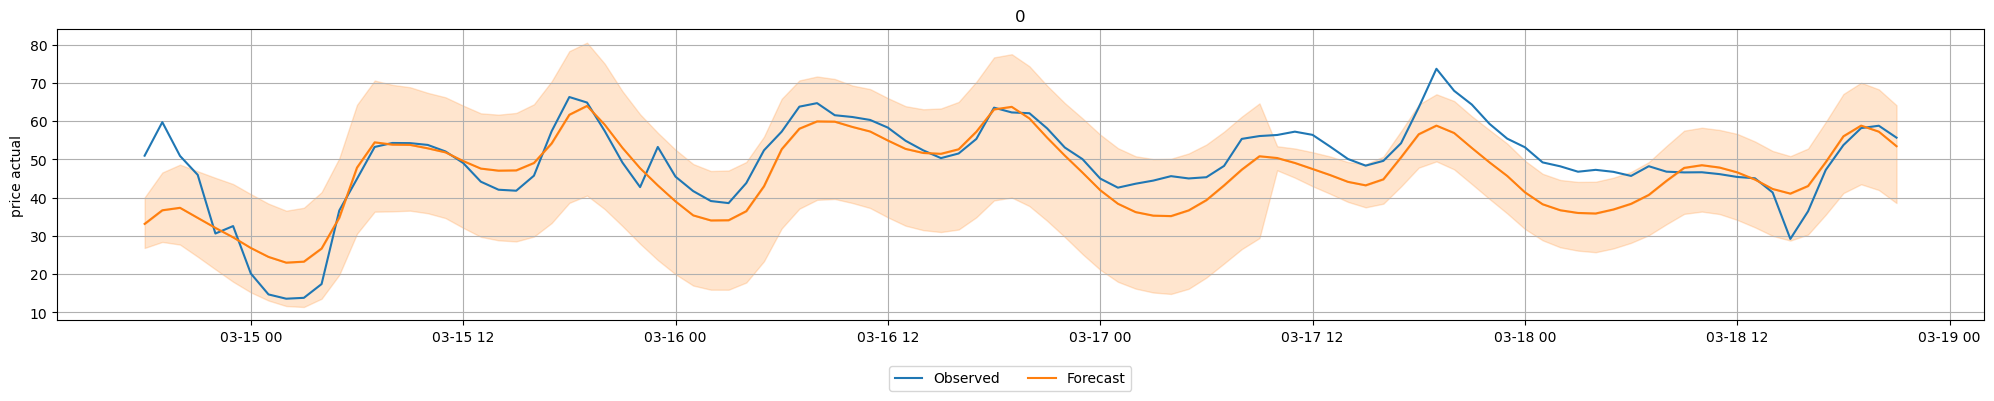

In [557]:
# Slice the test_data to only get the first 100 hours (assuming 'time' is the timestamp column)
first_100_hours = test_data.iloc[:100]

# Plot the first 100 hours of test_data vs predictions
predictor.plot(first_100_hours, predictions, item_ids=[0])


for Idan - What should I do more with models? maybe I should use the chronos with the source code for begin able to play more with the forecasting? or maybe should I do finetuning?